# TIME SERIES FORECASTING ANALYSIS FOR CORPORATION FAVORITA

# Project Description

The primary focus of this project is to utilize time series regression analysis to forecast sales for Corporation Favorita, a prominent grocery retailer based in Ecuador.

The objective is to develop a robust model capable of accurately forecasting future sales by leveraging the extensive time series data of thousands of products sold across various Corporation Favorita locations. The resulting forecasts will provide valuable insights to the store's management, enabling them to formulate effective inventory and sales plans.

I will utilize the CRISP-DM framework to execute the project.

# Business Understanding

Sales is the primary parameter for measuring the success of any business, and Corporation Favorita is no exception. The business has the data of its sales from 2013 to 2017 across its stores located in different cities in Ecuador.

During this time period, there have been holiday events, increases in oil price, and an earthquake in Ecuador. The grocery store management will like to know the impact of these occurrences on its sales. The management also wants to know the sales performance of its stores across different store types, clusters, cities and states.

Furthermore, the management will like to know if there is a trend in the sales data, as well as the occurrence of seasonality to help identify the buying patterns of customers and prepare adequately for periods in the future where peak sales usually occur. The impact of promotion on sales is another key factor the business wants to derive insights on.

This project is aimed at providing these business insights by performing regression analysis using the available time-stamped historical data. In addition, a scientific hypothesis will be established, and an optimal time-series regression model will be built to predict future sales. This prediction will ensure strategic decision-making in the future.

By delving into the project, my goal is to support the management team of Corporation Favorita in extracting meaningful insights from their vast data, optimize operations and ultimately achieve sales growth, and help drive data-informed decision-making.

# Hypothesis

Null Hypothesis: There is no significant difference in sales before and after promotion.

Alternate Hypothesis: There is a significant difference in sales before and after promotion.

# Analytical Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores making more sales than others? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

8. What is the total sales made each year by the corporation?

In [1]:
# Installations

# !pip install pyodbc
# !pip install python-dotenv
# !pip install sqlalchemy
# !pip install lightgbm
# !pip install xgboost
# !pip install catboost
# !pip install pmdarima

In [124]:
# Import the needed packages
import pandas as pd
import numpy as np

# Libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.dates as ndates
import seaborn as sns

# Libraries to create connection string to SQL server
import pyodbc
from dotenv import dotenv_values

# Library for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Library for checking stationarity
from statsmodels.tsa.stattools import adfuller

# Library for sample t-test
from scipy import stats

# Library for feature scaling
from sklearn.preprocessing import MinMaxScaler

# Library for feature encoding
from sklearn.preprocessing import OneHotEncoder

# Libraries for modelling
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Libraries for calculating evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer

# Library to make series stationary
from scipy.stats import boxcox

# Library for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Library for working with operating system
import os

# Library for saving the model components to a file
import pickle

# Library for creating zip file
import zipfile

# Library to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Data Understanding

### Accessing and loading the datasets

The holiday, oil and store datasets were collected from Azubi Africa's SQL database. The database credentials were hidden in a '.env' file and accessed using an environment variable as shown below. You can directly access the datasets in the root folder of this project's repository.

In [4]:
# Create an environment variable to access the database credentials in the '.env' file
environment_variable = dotenv_values('.env')

# Get the values for the credentials in the '.env' file
server = environment_variable.get('SERVER')
database = environment_variable.get('DATABASE')
username = environment_variable.get('USERNAME')
password = environment_variable.get('PASSWORD')

The database credentials accessed above using the environment variable will then be passed into a connection string dictionary created below. The connection string is an f-string that includes all the database credentials, and is used to establish a connection to the database server. After loading the connection string, SQL queries were used to obtain the datasets from the database.
     
##### In case the database becomes inaccessible, proceed with loading the datasets directly as shown in the next cell.

In [ ]:
# Create the connection string
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

# Pass the connection string using the connect method of the pyodbc library

connection = pyodbc.connect(connection_string) # Check your internet connection if it takes more time than necessary

# Get the oil dataset using the SQL query shown below
query1 = 'Select * from dbo.oil'
oil = pd.read_sql(query1, connection)

# Get the holiday dataset using the SQL query shown below
query2 = 'Select * from dbo.holidays_events'
holiday = pd.read_sql(query2, connection)

# Get the stores dataset using the SQL query shown below
query3 = 'Select * from dbo.stores'
stores = pd.read_sql(query3, connection)

# Save the datasets
oil.to_csv(r'oil.csv')
holiday.to_csv(r'holiday.csv')
stores.to_csv(r'stores.csv')

# Close connection
connection.close

In [6]:
# Load the datasets from the SQL database saved in the Assets folder
holiday = pd.read_csv('holiday.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')

# Drop the 'Unnamed: 0' column that would be present in each dataset after loading them directly
# The 'Unnamed: 0' column is an unnecessary column that mimicks the 'ID' column (index column) of the datasets
oil.drop(columns=['Unnamed: 0'], inplace=True)
holiday.drop(columns=['Unnamed: 0'], inplace=True)
stores.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
# Loading other datasets in the Assets folder

transactions = pd.read_csv('transactions.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### EDA

In [8]:
# Load the first five rows of the holiday dataset

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
# Identify the unique features of the 'type' column

holiday['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

The holidays whose type are designated as 'Transfer' are the holidays that occured on a particalar date but were observed on a different date. These holidays officially fall on the specified calendar date but were moved to another date by the government. This could be because the holidays occured in a weekend, or for any other reason. Since we are interested in the store sales performance on the actual days that holidays were observed, the holidays with type as 'Trasfer' will be isolated, and their holiday date changed to the actual date each holiday was observed.

In [10]:
# Filter holidays with 'type' as 'Transfer'
transferred_holidays = holiday[holiday['type'] == 'Transfer']

# Display the holidays with 'type' as 'Transfer'
transferred_holidays

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [11]:
# Function to change the date of transferred holidays to the date the holidays were observed
def change_transferred_holidays_date(row):
    if row['type'] == 'Transfer':
        corresponding_row = holiday[(holiday['description'] == row['description']) & 
                                               (holiday['type'] != 'Transfer') & 
                                               (holiday['date'] != row['date'])]
        if not corresponding_row.empty:
            return corresponding_row.iloc[0]['date']
    return row['date']

# Apply the function to change the date of transferred holidays to the date the holidays were observed
holiday['date'] = holiday.apply(change_transferred_holidays_date, axis=1)

# Drop any duplicate rows created
holiday.drop_duplicates(inplace=True)

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [12]:
# Load the first five rows of the stores dataset

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [13]:
# Check the datatypes of the columns in stores dataset

stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

In [14]:
# Change the datatypes of the columns (except 'store_nbr') in stores dataset to category for consistency and ease in handling the dataset
stores['city'] = stores['city'].astype('category')
stores['state'] = stores['state'].astype('category')
stores['type'] = stores['type'].astype('category')
stores['cluster'] = stores['cluster'].astype('category')

# Verify the changes
stores.dtypes

store_nbr       int64
city         category
state        category
type         category
cluster      category
dtype: object

In [15]:
# Load the first five rows of the oil dataset

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [16]:
# Load the first five rows of the transactions dataset

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [17]:
# Load the first five rows of the train dataset

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [18]:
# Load the first five rows of the test dataset

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [19]:
# Load the first five rows of the sample_submission dataset

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [20]:
# Create a dictionary of the datasets

data = {'holiday': holiday, 'stores': stores, 'oil': oil, 'transactions': transactions, 'train': train, 'test': test, 'sample_submission': sample_submission}

In [21]:
# Check the datatypes and presence of missing values in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')

For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int64   
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(4), int64(1)
memory usa

In [22]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')

For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 43
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________


For test dataset
Shape: (28512, 5)
Missing values = 0
Duplicates = 0
______________________________


For sample_submission dataset
Shape: (28512, 2)
Missing values = 0
Duplicates = 0
______________________________




# Problems Identified

The datasets are seperate, and need to be merged together for better analysis.

The oil dataset has 43 missing values on the 'dcoilwtico' column. This will be filled after merging the datasets. This column represents the oil price in Ecuador during the time period the data was gathered. The column name will be changed to 'oil_price' for easier identifcation and understanding of it's features.

There is no column to precisely identify the days in which there were holidays and days in which there were no holidays. This column will be created after merging and named 'holiday_status' as it will be important for our analysis.

The 'date' columns of each dataset have an object datatype. This will be changed to datetime datatype after merging.

# Data Preparation

The problems identified with the datasets will be handled in preparation for analysis and modelling.

### Merge the datasets based on common columns

In [23]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holiday, on='date', how='left')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date', how='left')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr', how='left')

df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [24]:
# Check for missing values after merging the datasets

df4.isna().sum().sum()

13972299

There are dates with values on a dataset that are not represented at all on another dataset. When these datasets are merged, the rows of such dates will have missing values. This is one of the reasons for the huge amount of missing values in the merged dataset. Another reason is that the oil dataset has some missing values of it's own which were introduced to the merged dataset. These missing values will be filled subsequently.

In [25]:
# Check for duplicates after merging the datasets

df4.duplicated().sum()

0

In [26]:
# Create a copy of the merged dataset for further exploration

df = df4.copy()

In [59]:
# Drop the 'id' column as it is unnecessary

df.drop(columns=['id'], inplace=True)

In [27]:
# Identify the features of 'type_x' column in the merged dataset

df['type_x'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

Observe that the features of this column are same with the 'type' column of the holiday dataset. This column will be renamed to 'holiday_type' for easier identification. Also observe that there are missing values in this column as revealed by the presence of 'nan'. This will be handled while handling missing values subsequenty.

In [28]:
# Identify the features of 'type_y' column in the merged dataset

df['type_y'].unique()

['D', 'C', 'B', 'E', 'A']
Categories (5, object): ['A', 'B', 'C', 'D', 'E']

Observe that the features of this column are same with the 'type' column of the store dataset. This column will be renamed to 'store_type' for easier identification.

In [29]:
# Rename 'type_x', 'dcoilwtico' and type_y' to 'holiday_type', 'oil_price' and 'store_type' respectively

df = df.rename(columns={'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y': 'store_type'})
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


### Filling missing values

In [30]:
# Identify the columns with missing values

df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2553606
locale          2553606
locale_name     2553606
description     2553606
transferred     2553606
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

The missing values in the transactions column will be filled with 0 because it represents the absence of transactions on those days.

In [31]:
# Fill the missing values in the transactions column with 0

df['transactions'].fillna(0, inplace=True)
df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions          0
holiday_type    2553606
locale          2553606
locale_name     2553606
description     2553606
transferred     2553606
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

For holiday_type, locale, locale_name, description and transferred columns, there are equal number of missing values. This is because these columns are from the holiday dataset, and they represent the days where there were no holidays. These empty cells will be filled with 'No holiday' for easy identification.

In [32]:
# Fill the missing values in type_x, locale, locale_name, description and transferred columns with 'No holiday'
columns_to_fill = ['holiday_type', 'locale', 'locale_name', 'description', 'transferred']
for column in columns_to_fill:
        df[column].fillna('No holiday', inplace=True)

# Confirm that there are no more missing values in these columns
df.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
oil_price       955152
city                 0
state                0
store_type           0
cluster              0
dtype: int64

<Axes: >

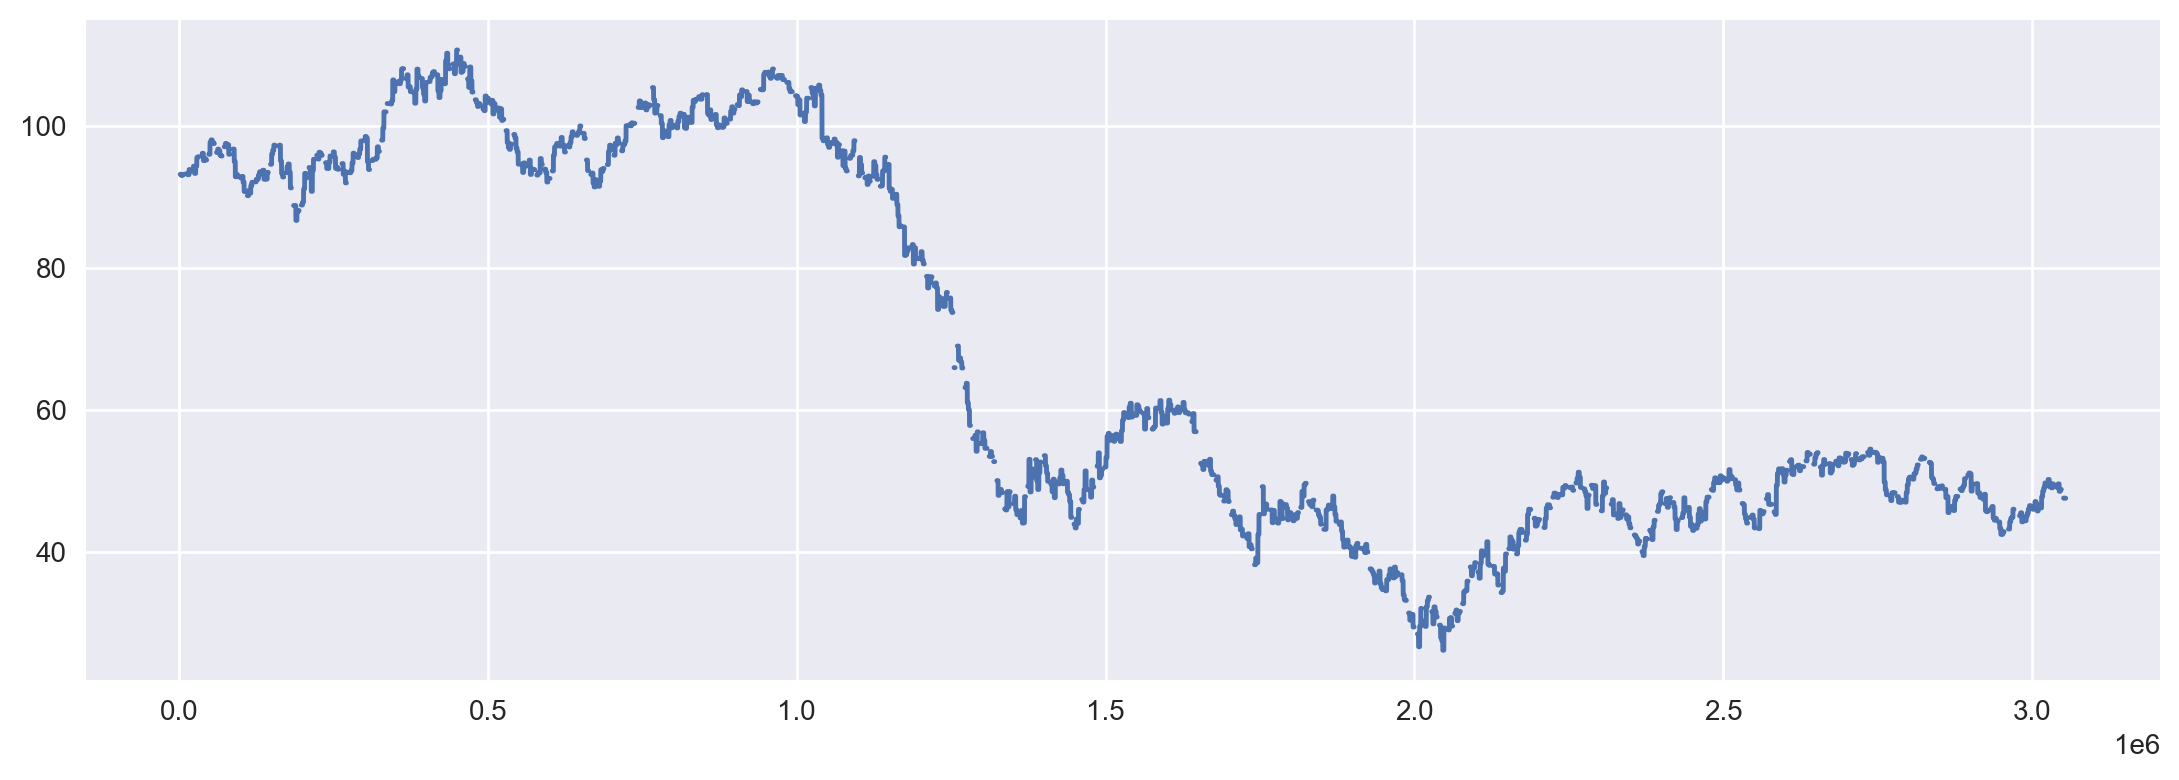

In [33]:
# Visualize the trend of oil prices before filling the missing values in the 'oil_price' column

df['oil_price'].plot()

The chart above reveals that there is a trend formed as the oil price changes. For this reason, the missing values in the 'oil_price' column will be filled using backward fill to ensure continuity in the trend.

In [34]:
# Fill the missing values in the 'oil_price' column using backward fill
df['oil_price'].fillna(method='bfill', inplace=True)

# Confirm that there are no more missing values in the merged dataset
df.isna().sum().sum()

0

<Axes: >

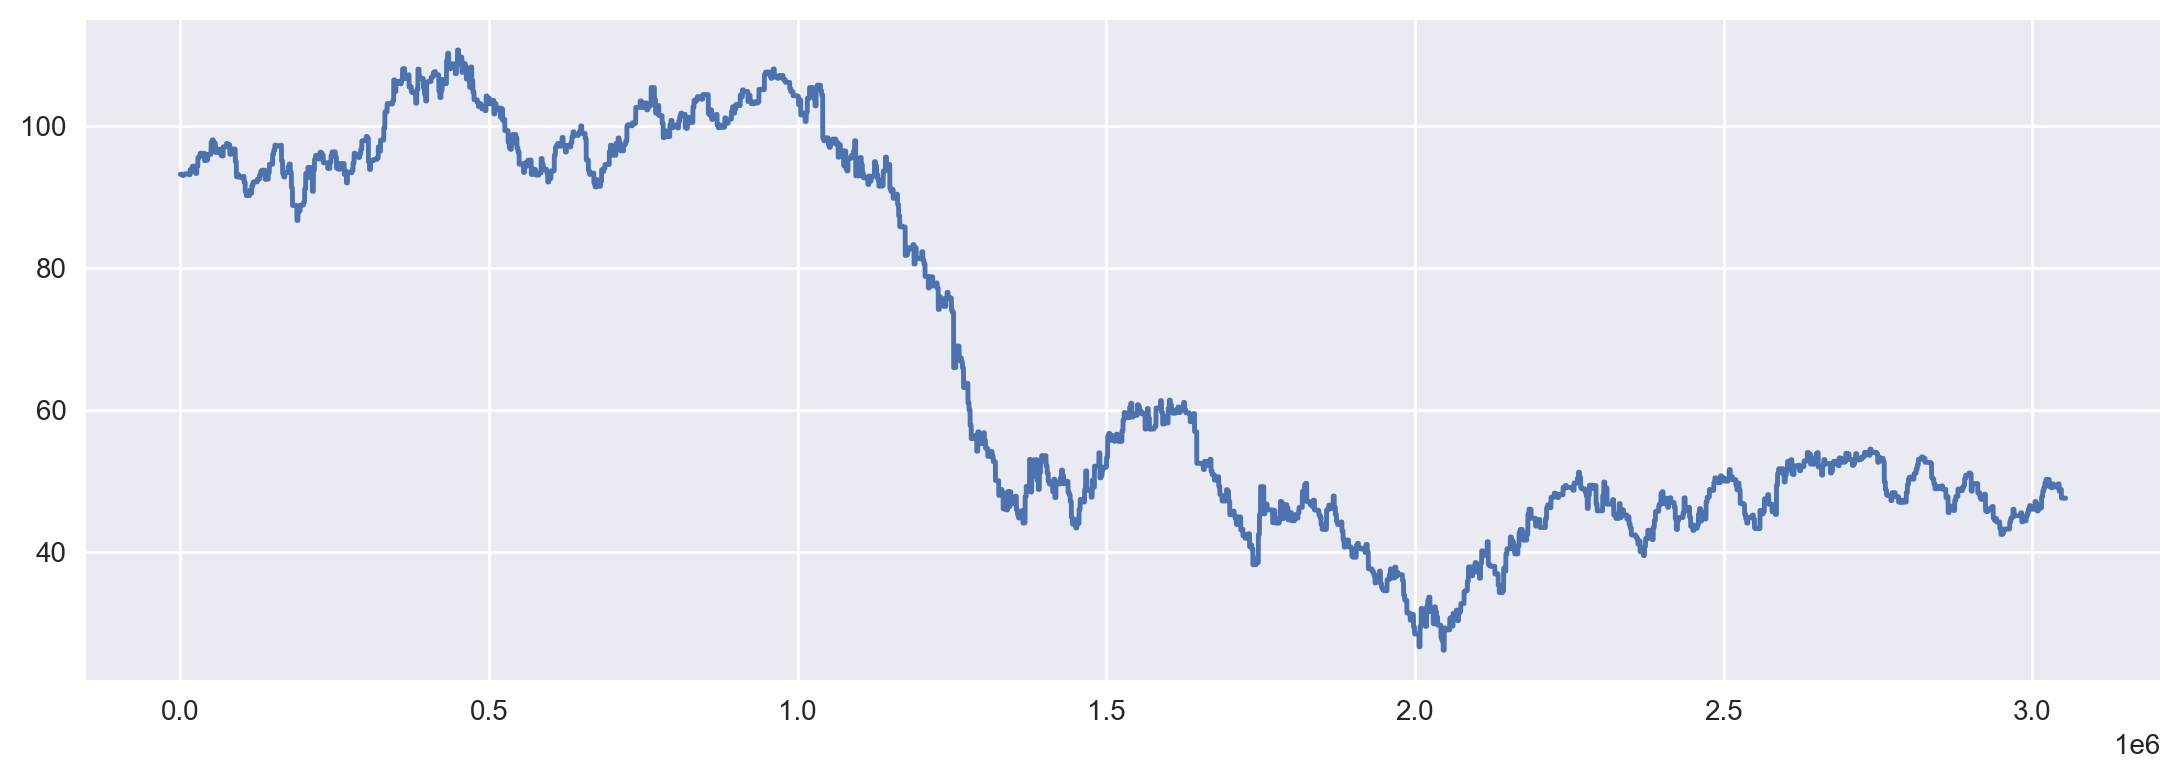

In [35]:
# Visualize the trend of oil prices after filling the missing values

df['oil_price'].plot()

As shown above, the continuity of the trend was maintained after filling the missing values in the 'oil_price' column.

### Create the 'holiday_status' column

In [36]:
# Check the unique values of the 'holiday_type' column

df['holiday_type'].unique()

array(['Holiday', 'No holiday', 'Work Day', 'Additional', 'Event',
       'Transfer', 'Bridge'], dtype=object)

In [37]:
# Function to map holiday type to holiday status
def map_holiday_status(holiday_type):
    if holiday_type in ['No holiday', 'Work Day']:
        return 'No holiday'
    else:
        return 'Holiday'

# Add the 'holiday_status' column using the 'holiday_type' column
df['holiday_status'] = df['holiday_type'].apply(map_holiday_status)
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday


In [38]:
# Check the unique values of the 'holiday_status' column

df['holiday_status'].unique()

array(['Holiday', 'No holiday'], dtype=object)

### Change the datatype of the 'date' column from object to datetime

In [39]:
# Change the datatype of the date column to datetime
df['date'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 18 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   date            datetime64[ns]
 2   store_nbr       int64         
 3   family          object        
 4   sales           float64       
 5   onpromotion     int64         
 6   transactions    float64       
 7   holiday_type    object        
 8   locale          object        
 9   locale_name     object        
 10  description     object        
 11  transferred     object        
 12  oil_price       float64       
 13  city            category      
 14  state           category      
 15  store_type      category      
 16  cluster         category      
 17  holiday_status  object        
dtypes: category(4), datetime64[ns](1), float64(3), int64(3), object(7)
memory usage: 337.9+ MB


In [40]:
# Create new features from the 'date' column using pandas' powerful time-based indexing

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dayofmonth'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['dayname'] = df.date.dt.strftime('%A')

df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday


In [41]:
# Set the 'date' column as index

df = df.set_index('date')
df.head()

,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday


In [60]:
# Rename df to train_data

train_data = df.copy()

In [43]:
# Display random sample of 8 rows

train_data.sample(8, random_state = 42)

,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2014-01-07,659843,23,DAIRY,471.000,0,1135.0,No holiday,No holiday,No holiday,No holiday,...,Ambato,Tungurahua,D,9,No holiday,2014,1,7,1,Tuesday
2014-12-05,1250966,1,BEAUTY,1.000,0,2028.0,Additional,Local,Quito,Fundacion de Quito-1,...,Quito,Pichincha,D,13,Holiday,2014,12,5,4,Friday
2014-07-06,981404,45,HOME APPLIANCES,0.000,0,4626.0,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,A,11,No holiday,2014,7,6,6,Sunday
2014-05-02,864686,20,LAWN AND GARDEN,0.000,0,0.0,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,B,6,No holiday,2014,5,2,4,Friday
2014-02-25,747235,25,HOME AND KITCHEN II,0.000,0,705.0,No holiday,No holiday,No holiday,No holiday,...,Salinas,Santa Elena,D,1,No holiday,2014,2,25,1,Tuesday
2014-01-26,694647,49,PRODUCE,7866.909,0,2744.0,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,A,11,No holiday,2014,1,26,6,Sunday
2014-11-23,1231012,49,GROCERY II,107.000,0,3096.0,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,A,11,No holiday,2014,11,23,6,Sunday
2013-08-24,419196,20,PRODUCE,0.000,0,0.0,Holiday,Local,Ambato,Fundacion de Ambato,...,Quito,Pichincha,B,6,Holiday,2013,8,24,5,Saturday


Text(0.5, 0, 'Year')

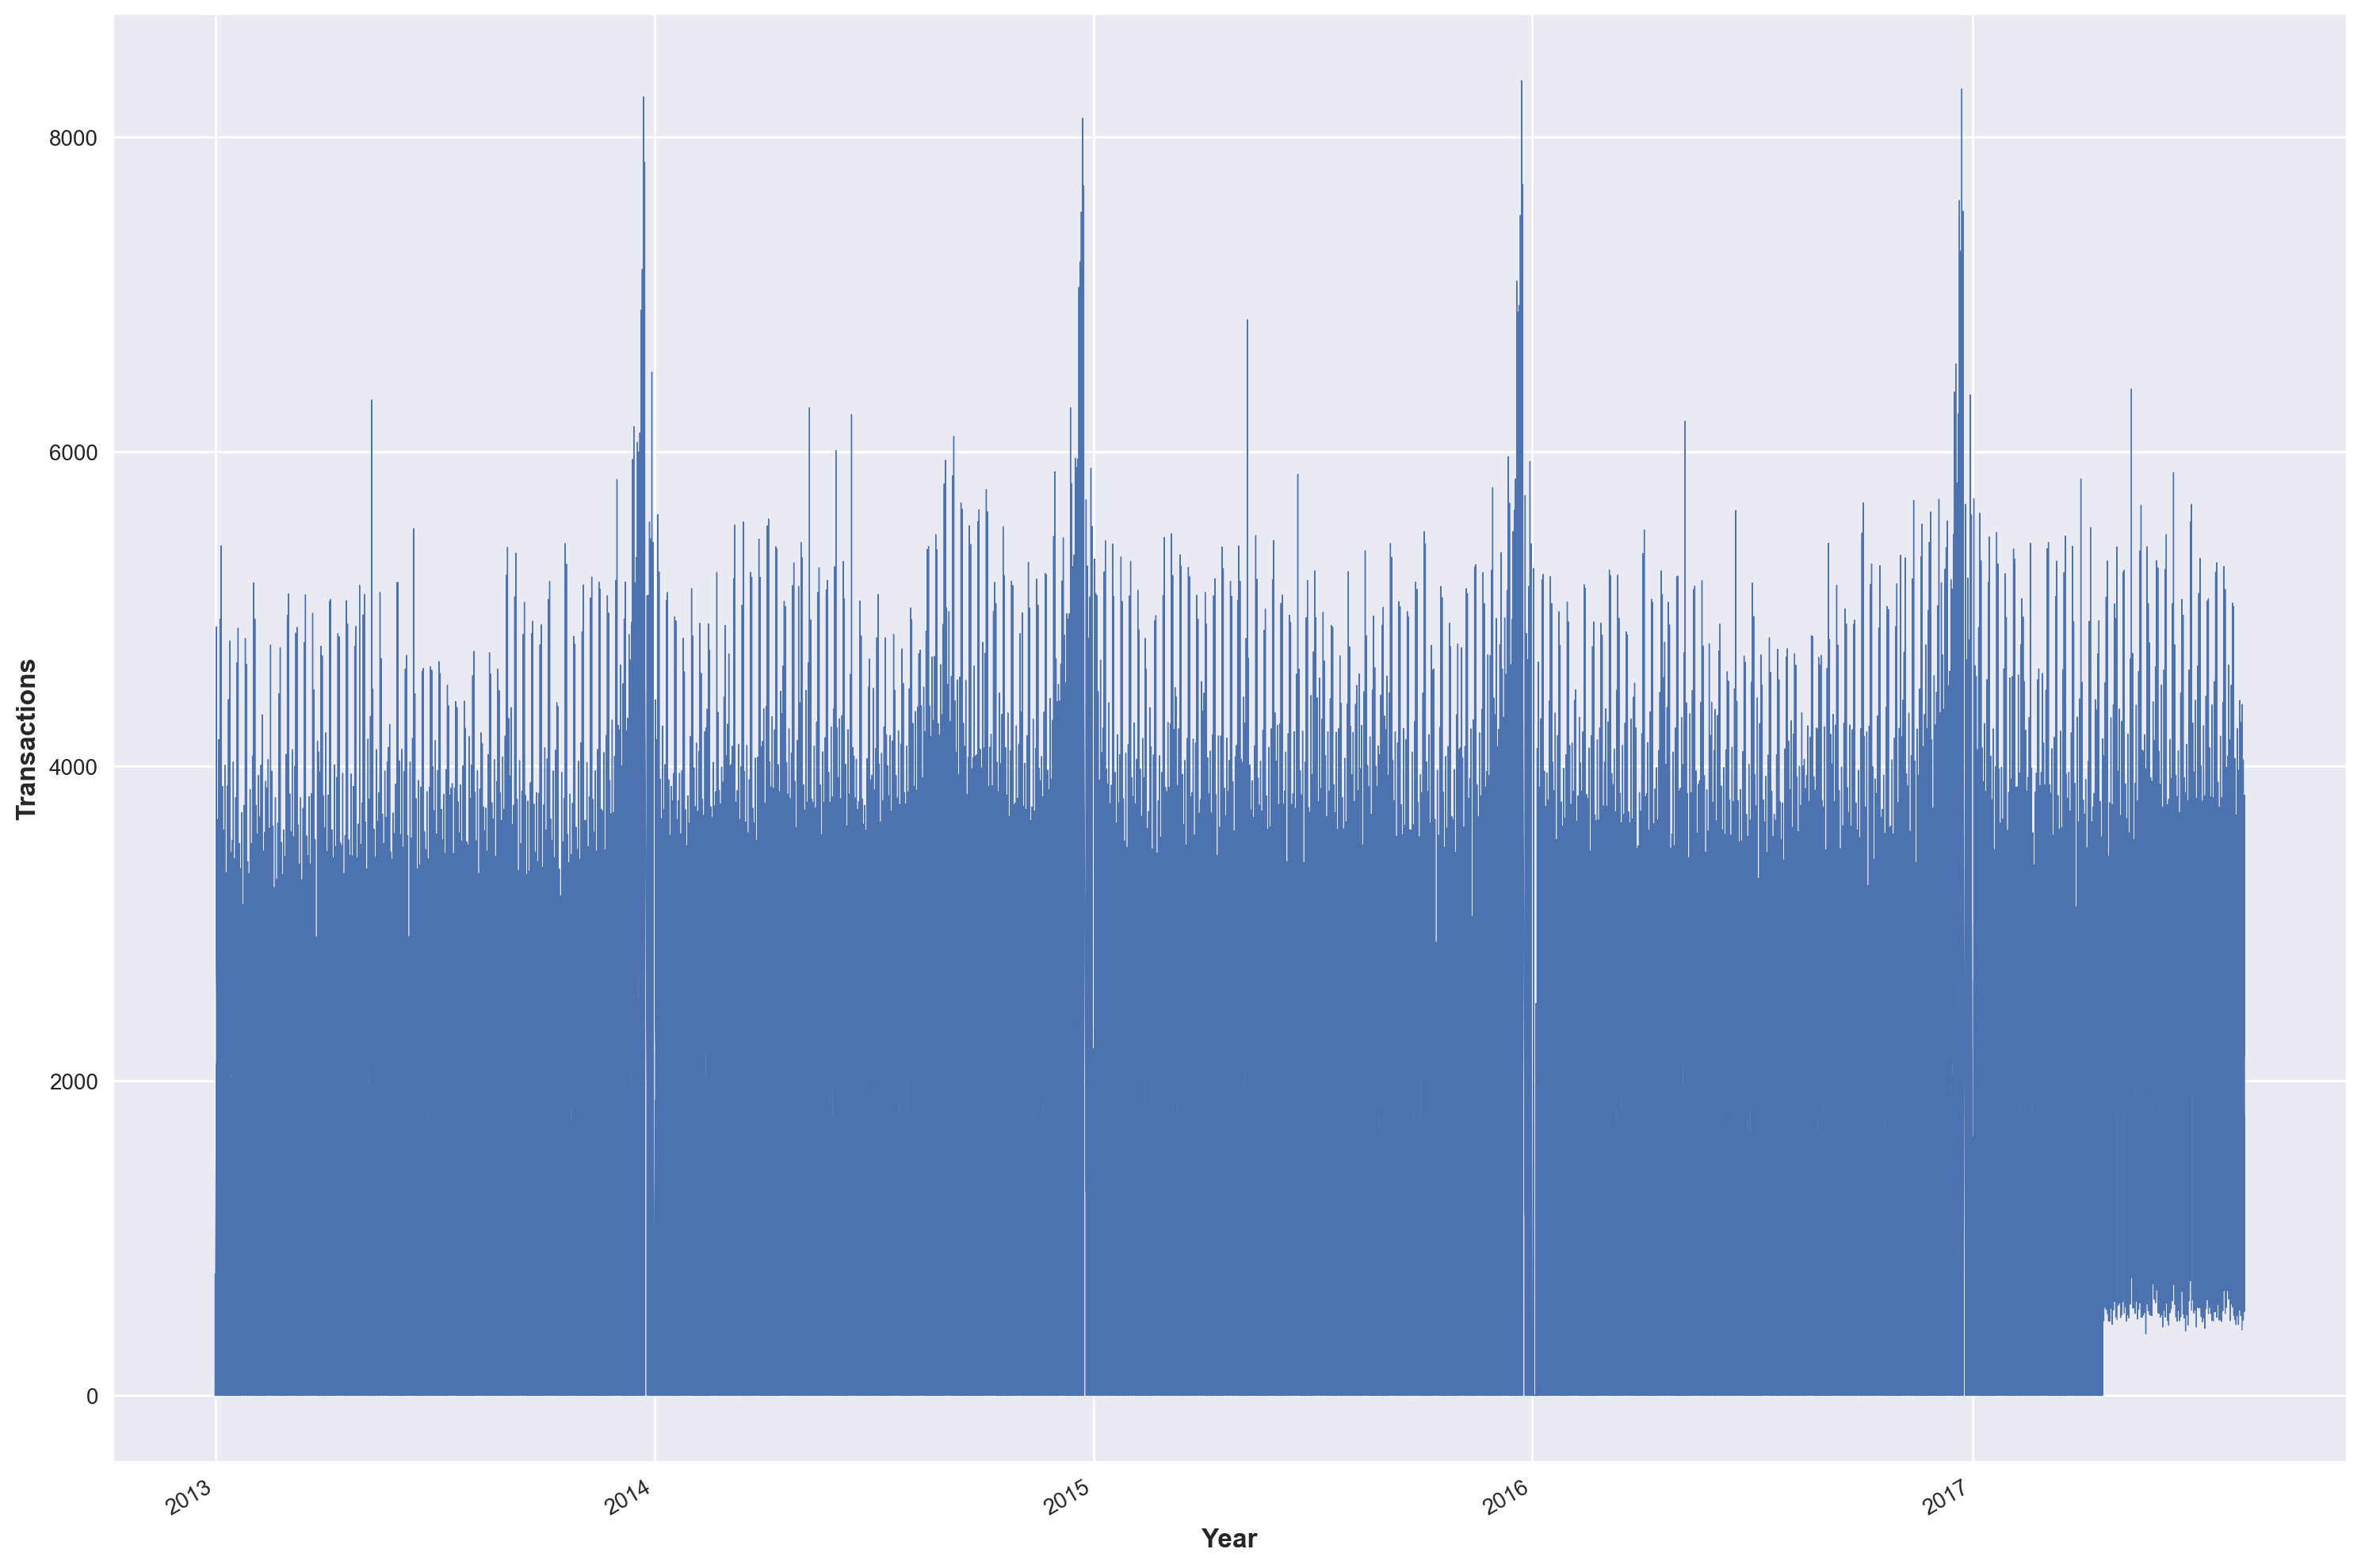

In [44]:
# Visualize the 'transactions' column

plt.figure(figsize=(15,10))
ax = train_data['transactions'].plot(linewidth=0.5)
ax.set_ylabel('Transactions')
ax.set_xlabel('Year')

The plot above reveals that transactions are always highest at the end of each year. This reveals seasonality in the dataset.

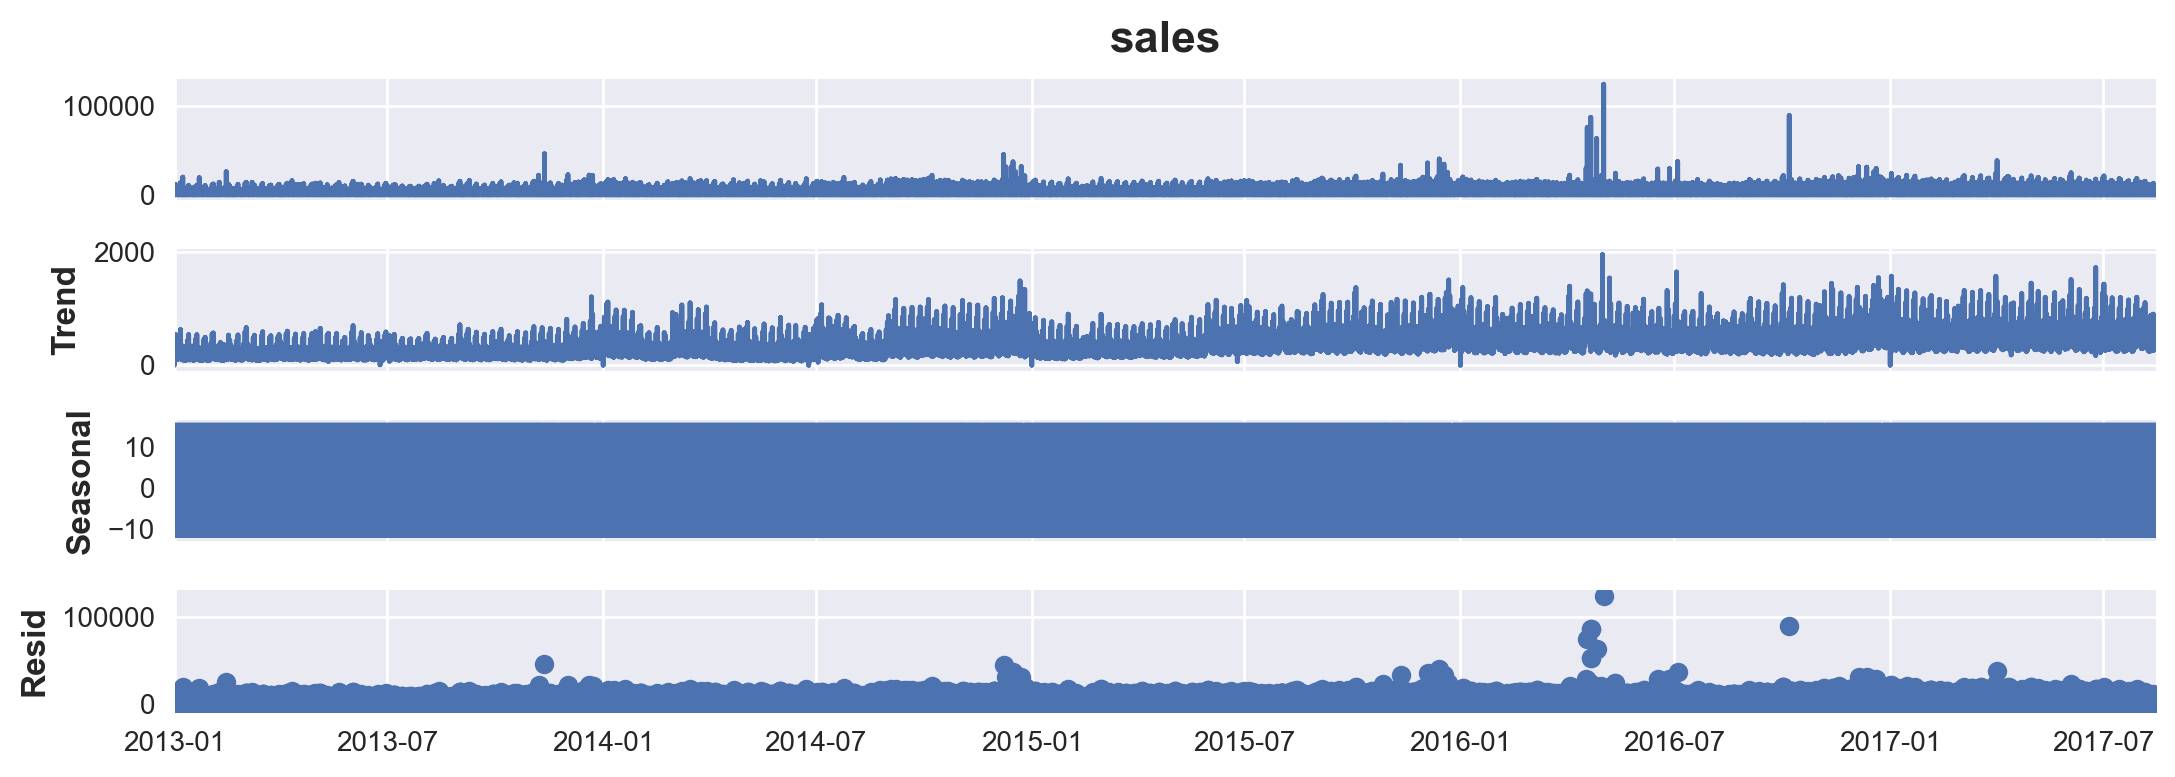

In [45]:
# Perform seasonal decomposition

result = seasonal_decompose(train_data['sales'], model='additive', period=365)
result.plot()
plt.show()

Seasonal decomposition is a technique used in time series analysis to gain a better understanding of the underlying structure and patterns within the time series dataset by breaking down the dataset into its constituent components, which are typically the following:

**Trend Component:** This component represents the long-term movement or direction in the data. It captures the underlying pattern in the data that persists over time. For example, in a retail sales time series, the trend component might represent the overall growth or decline in sales over multiple years. For our dataset, the trend component shows an overall growth in sales over the years as there is a generally upward trending pattern in sales. 

**Seasonal Component:** The seasonal component captures the repeating patterns or fluctuations in the data that occur at fixed intervals, such as daily, weekly, monthly, or yearly. These patterns are often associated with external factors like seasons, holidays, or other recurring events. For our dataset, the fully colored seasonal component indicates prominent recurring patterns at fixed intervals, likely due to seasonal factors influencing sales.

**Residual Component (or Error):** The residual component represents the unexplained or random variations (noise or irregularities) in the data after removing the trend and seasonal components. For our dataset, the residual component shows less random behavior.

##### Performing seasonal decomposition serves several important purposes:

***Pattern Identification:*** Decomposition helps identify and isolate the underlying patterns, trends, and seasonal effects in the data. This information can be valuable for making predictions and informed decisions.

***Anomaly Detection:*** Separating out the trend and seasonal components makes it easier to identify and detect unusual or anomalous behavior in the data. Any deviations from the expected pattern can be more readily spotted in the residual component.

***Forecasting:*** Once the time series is decomposed, you can model and forecast each component separately. This allows for more accurate and interpretable predictions. For example, you can forecast the trend and seasonality separately and then combine them to make a final prediction.

***Data Analysis and Visualization:*** Decomposition provides a cleaner and clearer way to visualize and analyze the individual components, making it easier to communicate the insights to stakeholders.

***Modeling:*** Many time series forecasting models (example ARIMA or Exponential Smoothing models) work more effectively when applied to the individual components, potentially leading to better modelling results.


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

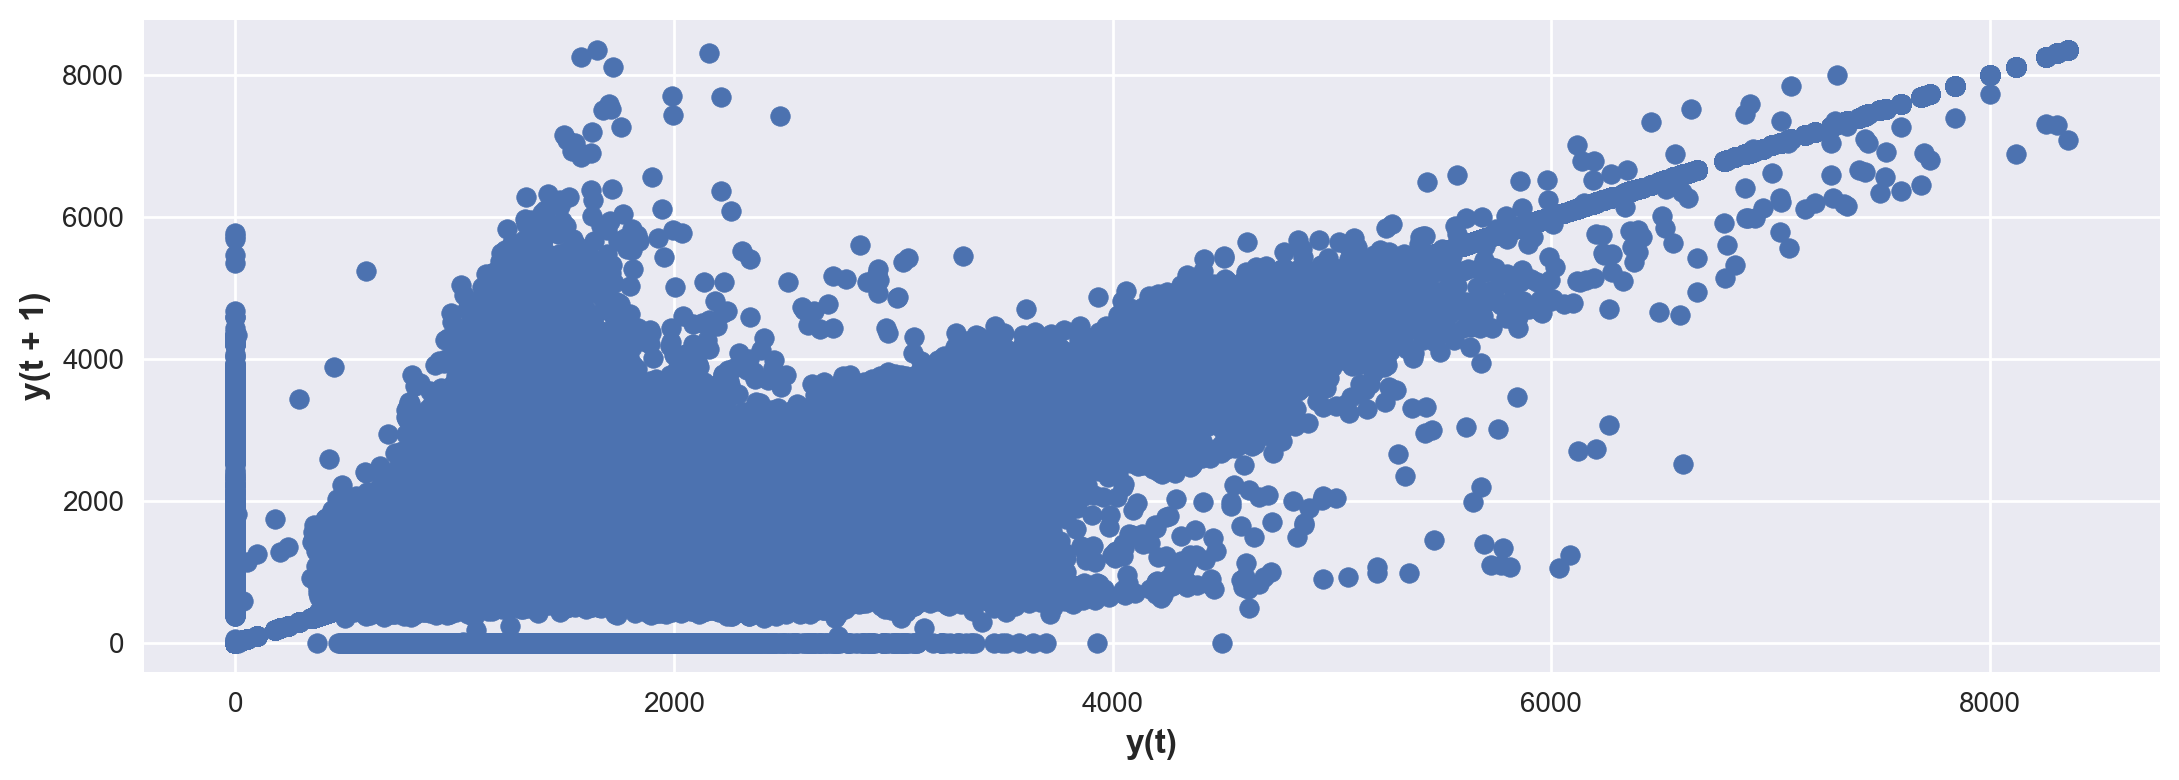

In [46]:
# Create a lag plot

pd.plotting.lag_plot(train_data['transactions'], lag=1)

A lag plot is a graphical tool used in time series analysis to examine the autocorrelation or serial correlation in a dataset. Autocorrelation refers to the correlation between a time series and a lagged version of itself, which can provide valuable insights into the underlying structure of the data. The lag plot helps in visualizing autocorrelation, identifying seasonality, assessing stationarity, model selection, detecting serial correlation, and checking residuals.

The lag plot above for our dataset reveals that there is clustering, linearity, and a few pattern deviations in the plot.

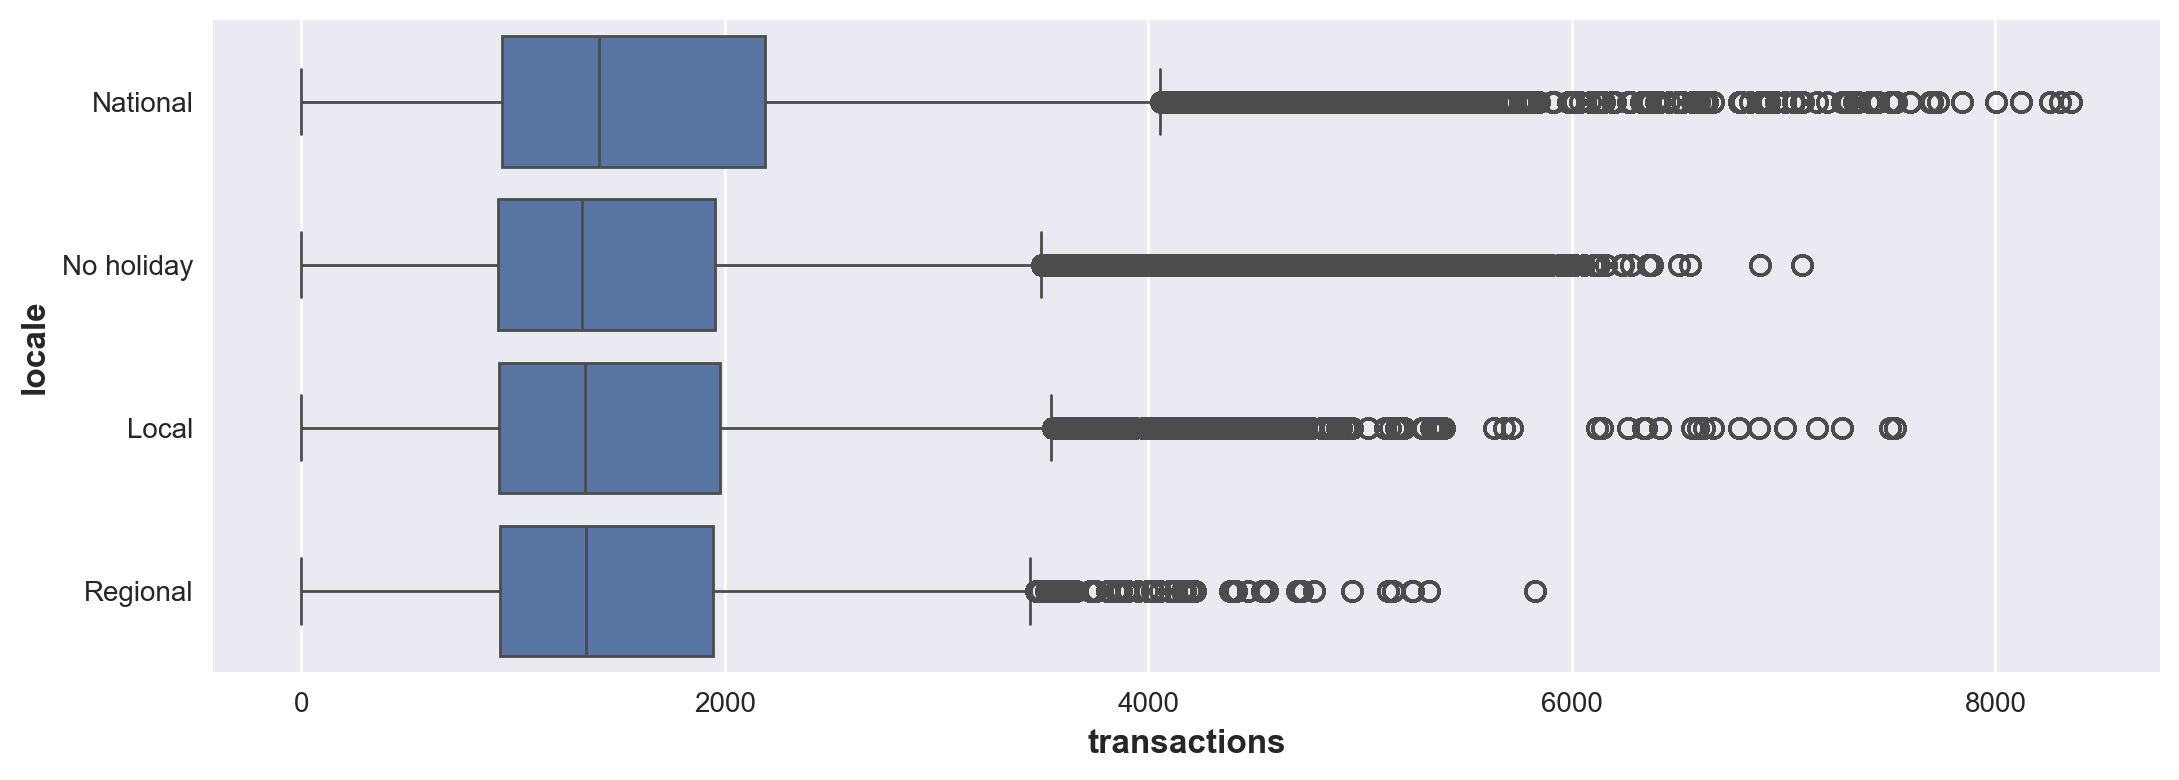

In [47]:
# Create a boxplot of the 'transactions' column grouped by 'locale'
sns.boxplot(x='transactions', y='locale', data=train_data)

# Save the boxplot as an image in the "Images" folder
plt.savefig("Images/Boxplot_of_the_transactions_column_grouped_by_locale.png", dpi=300)

# Show the plot
plt.show()

For the box plot above, the median (the line within the box) shows the central tendency of the data and is highest for 'National holidays'. Also, the length of the boxes show that 'transactions' on National Holidays have the greatest variability as it has the longest box. The data points that fall outside the whiskers of all the boxes indicate extreme values (outliers) or anomalies  with 'National holidays' having the most extreme values.

Based on the boxplot, there is evidence of significant variations in transaction patterns between locales.

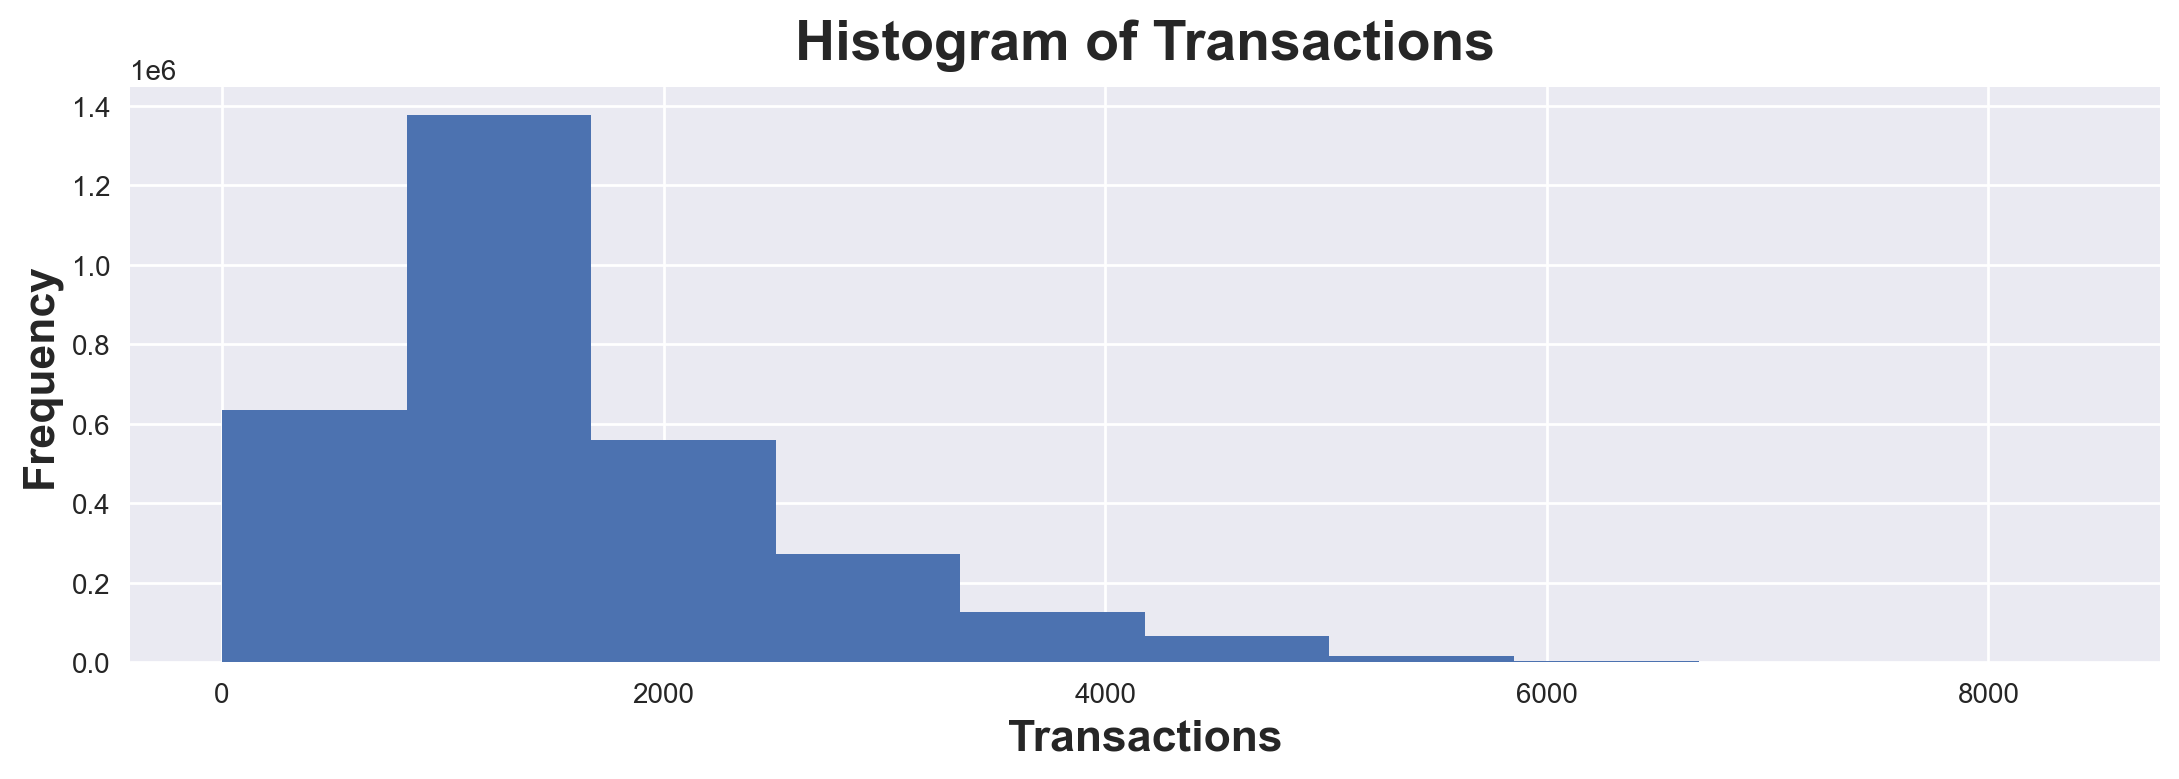

In [48]:
# Create a histogram of the 'transactions' column
train_data.transactions.hist()

# Add labels to the x-axis, y-axis, and title
plt.xlabel('Transactions', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Transactions', fontsize=20)

# Show the plot
plt.show()

The histogram suggests that most transactions fall within a certain range, around 800 to 1800, indicating a central trend. However, the presence of outliers may need further investigation. There is also a steady fall in the frequency of the transactions suggesting a steady transaction pattern.

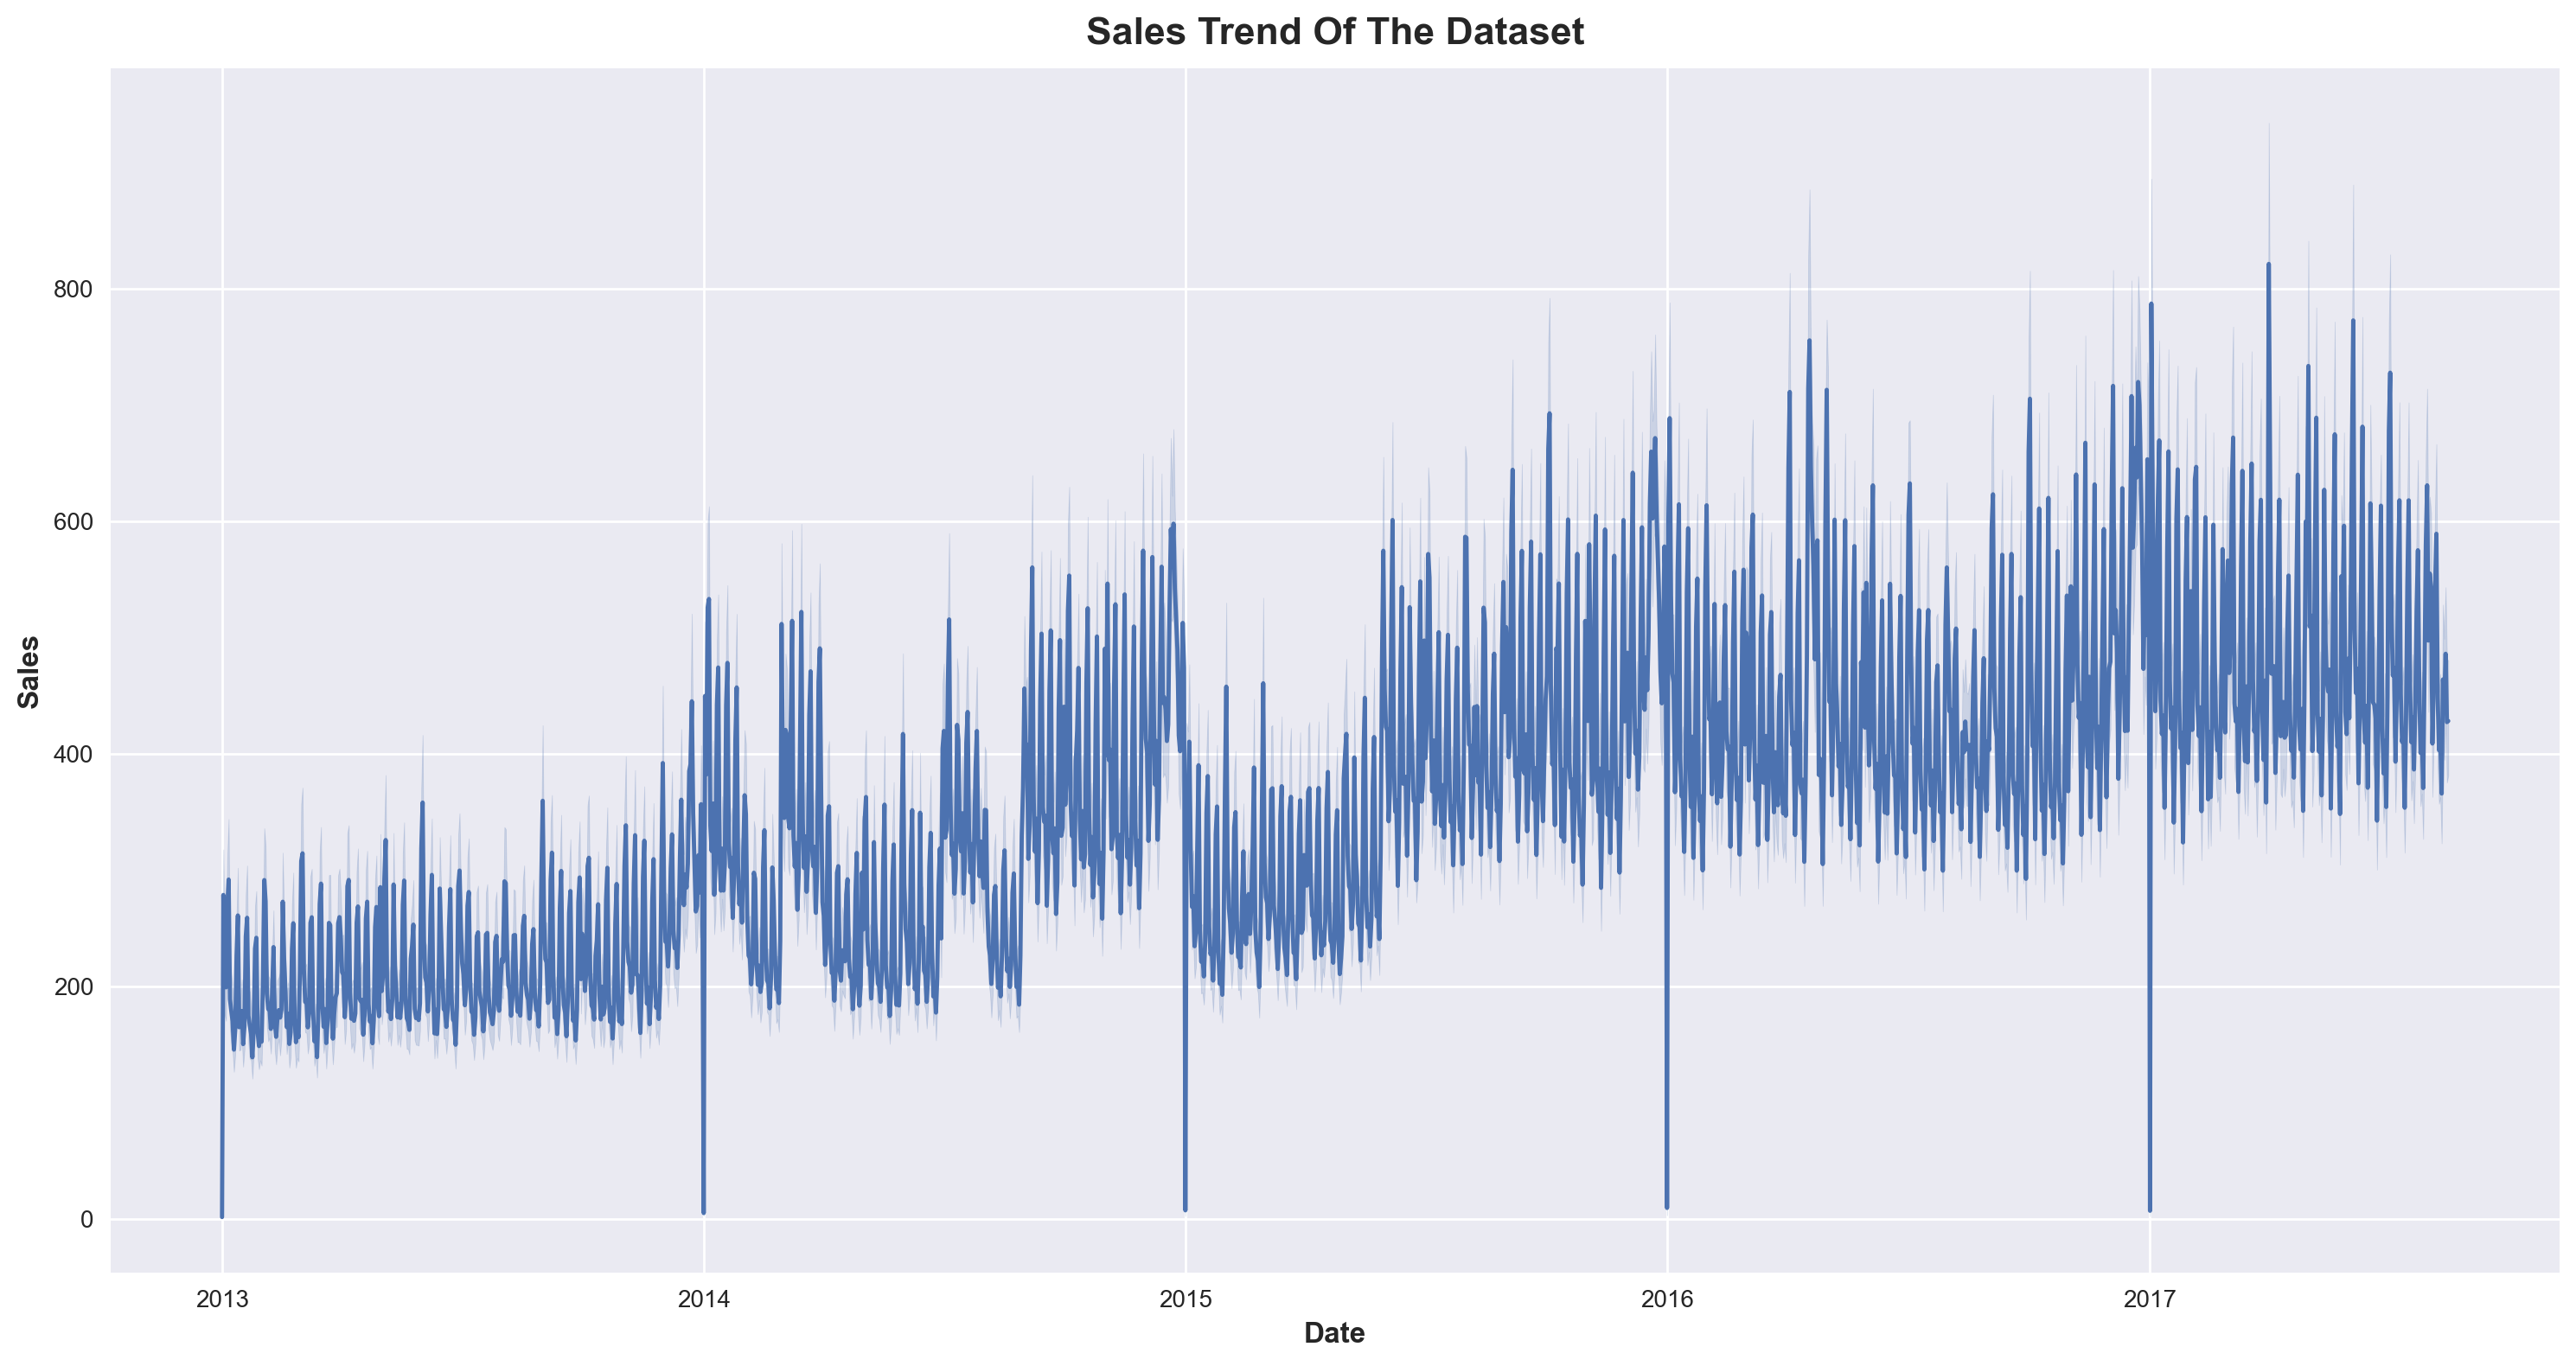

In [49]:
# Visualize the sales trend of the dataset

plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='sales', data=train_data)
plt.title('Sales Trend Of The Dataset')
plt.xlabel('Date')
plt.ylabel('Sales')

# Save the plot as an image in the "Images" folder
plt.savefig("Images/Sales_trend_of_the_dataset.png", dpi=300)

plt.show()

The image above shows that there is an upward trend in the sales recorded by the retail store over the years. Also there seem to be more sales at the end of each year compared to the beginning. Finally, at the very start of each year, there are zero sales which can be as a result of a usual holiday break for all the retail store staff.

In [50]:
# Generate summary statistics for numerical columns in train_data DataFrame

train_data.describe()

,id,store_nbr,sales,onpromotion,transactions,oil_price,year,month,dayofmonth,dayofweek
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,1.504277e+06,2.750000e+01,3.590209e+02,2.617480e+00,1.558656e+03,6.778930e+01,2.014842e+03,6.222870e+00,1.565694e+01,3.008168e+00
std,8.662610e+05,1.558579e+01,1.107286e+03,1.225494e+01,1.036468e+03,2.570258e+01,1.345607e+00,3.374251e+00,8.801398e+00,2.001442e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,7.546768e+05,1.400000e+01,0.000000e+00,0.000000e+00,9.310000e+02,4.628000e+01,2.014000e+03,3.000000e+00,8.000000e+00,1.000000e+00
50%,1.507572e+06,2.750000e+01,1.100000e+01,0.000000e+00,1.332000e+03,5.319000e+01,2.015000e+03,6.000000e+00,1.600000e+01,3.000000e+00
75%,2.255120e+06,4.100000e+01,1.960110e+02,0.000000e+00,1.980000e+03,9.580000e+01,2.016000e+03,9.000000e+00,2.300000e+01,5.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,8.359000e+03,1.106200e+02,2.017000e+03,1.200000e+01,3.100000e+01,6.000000e+00


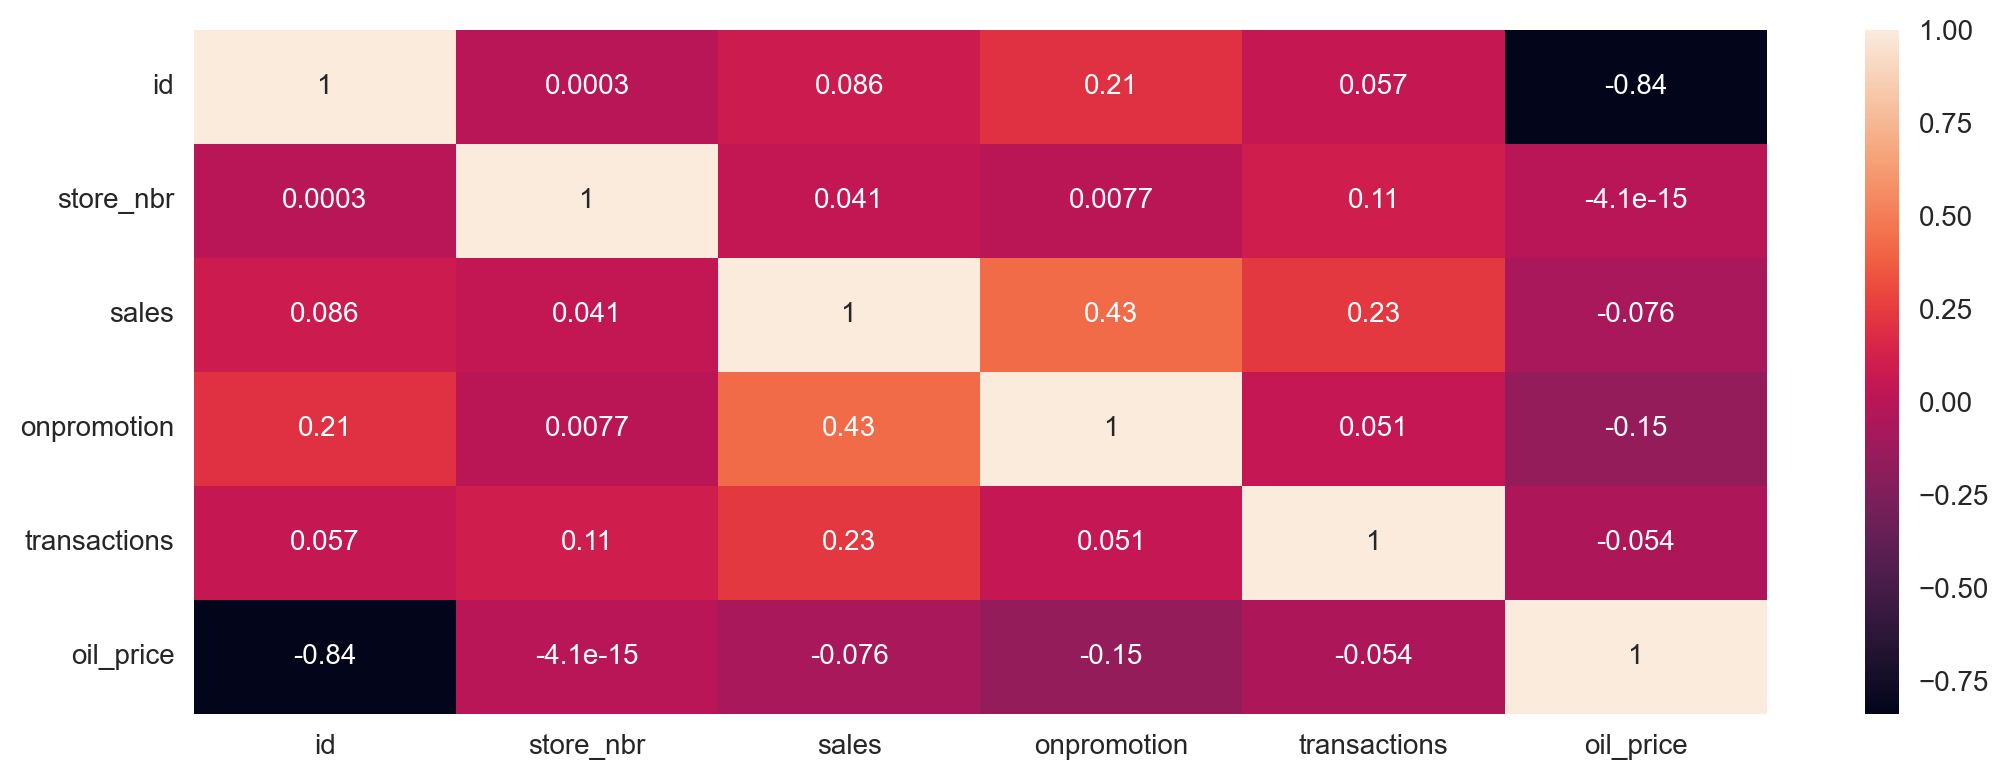

In [51]:
# Create a DataFrame of train_data with numerical columns only
train_data_num = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of the numerical columns
corr_matrix = train_data_num.corr()

# Visualizing the correlation matrix with a heatmap
sns.heatmap(corr_matrix, annot=True)

# Save the chart as an image file
plt.savefig('Images/Correlation_of_the_numerical_columns_of_the_train_dataset.png')

# Hypothesis Testing

Null Hypothesis: There is no significant difference in sales before and after promotion.

Alternate Hypothesis: There is a significant difference in sales before and after promotion.

In [120]:
# Select the sales data for product family before the promotion
sales_before_promotion = train_data.loc[(train_data['family'] == 'YOUR_PRODUCT_FAMILY') & (train_data['onpromotion'] == 0), 'sales']

# Select the sales data for product family after the promotion
sales_after_promotion = train_data.loc[(train_data['family'] == 'YOUR_PRODUCT_FAMILY') & (train_data['onpromotion'] == 1), 'sales']

# Perform the paired samples t-test
t_statistic, p_value = stats.ttest_rel(sales_before_promotion, sales_after_promotion)

if p_value < 0.05:
    print('Reject null hypothesis: There is a significant difference in sales before and after promotion')
else:
    print('Fail to reject null hypothesis: There is no significant difference in sales before and after promotion')

Fail to reject null hypothesis: There is no significant difference in sales before and after promotion


The null hypothesis is accepted as there is no significant difference in sales before and after promotion.

# Test for stationarity

##### The codes below were commented out because there is insufficient memory capacity to run it

In [53]:
# Test for stationarity using the ADF test
# adf_result = adfuller(train_merged['sales'])

# Print the test results
# print(f'ADF Statistic: {adf_result[0]}')
# print(f'p-value: {adf_result[1]}')
# print(f'Critical Values: {adf_result[4]}')

# Perform hypothesis testing
# alpha = 0.05  # Significance level

# if p_value <= alpha:
#     print("Reject the null hypothesis. Series is stationary.")
# else:
#    print("Fail to reject the null hypothesis. Series is not stationary.")

# Answering Analytical Questions

### Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores making more sales than others? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

8. What is the total sales made each year by the corporation?

### Question 1

##### Is the train dataset complete (has all the required dates)?

In [54]:
# Check the range of the date column
dates_range = pd.date_range(start=train_data.index.min(), end=train_data.index.max())

# Check for missing dates in the dataset
missing_dates = set(dates_range.date) - set(train_data.index.unique())

# Create a new dataframe with the dates_missing data
missing_dates_df = pd.DataFrame(missing_dates)
missing_dates_df.head()

,0
0,2015-10-12
1,2016-07-17
2,2017-07-02
3,2016-12-21
4,2014-07-17


In [55]:
# Check if April 16, 2016 (the date of the earthquake), is present in missing_dates_df
date_to_check = pd.to_datetime('2016-04-16')
is_april_16_present = date_to_check in missing_dates_df.values

print(" Is April 16, 2016, (the date of the earthquake) among the missing dates?:", is_april_16_present)

 Is April 16, 2016, (the date of the earthquake) among the missing dates?: False


Although the dates include April 16, 2016, (the date of the earthquake), there are other missing dates. This means that the dataset is not complete.

### Question 2

##### Which dates have the lowest and highest sales for each year?

The dates where the sales is 0 are most likely the dates that the stores were not open. Such days will not be seen as dates with the lowest sales because the store was not even open for sales at all.

In [56]:
# Group the data by year
grouped_data = train_data.groupby('year')

# Find the dates with the highest and lowest sales for each year, excluding the dates with zero sales
years = []
max_dates = []
max_sales = []
min_dates = []
min_sales = []

for year, group in grouped_data:
    nonzero_sales_group = group[group['sales'] > 0]
    if not nonzero_sales_group.empty:
        max_sale_date = nonzero_sales_group['sales'].idxmax()
        min_sale_date = nonzero_sales_group['sales'].idxmin()
        max_sale_value = nonzero_sales_group['sales'].max()
        min_sale_value = nonzero_sales_group['sales'].min()

        years.append(year)
        max_dates.append(max_sale_date)
        max_sales.append(max_sale_value)
        min_dates.append(min_sale_date)
        min_sales.append(min_sale_value)

# Create the result DataFrame
result_data = {
    'Year': years,
    'Highest_Sales_Date': max_dates,
    'Highest_Sales': max_sales,
    'Lowest_Sales_Date': min_dates,
    'Lowest_Sales': min_sales
}
result_df = pd.DataFrame(result_data)
result_df

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
0,2013,2013-11-12,46271.000,2013-08-06,0.122
1,2014,2014-12-08,45361.000,2014-12-05,0.188
2,2015,2015-12-14,40351.460,2015-09-15,0.196
3,2016,2016-05-02,124717.000,2016-06-23,0.396
4,2017,2017-04-02,38422.625,2017-02-09,0.426


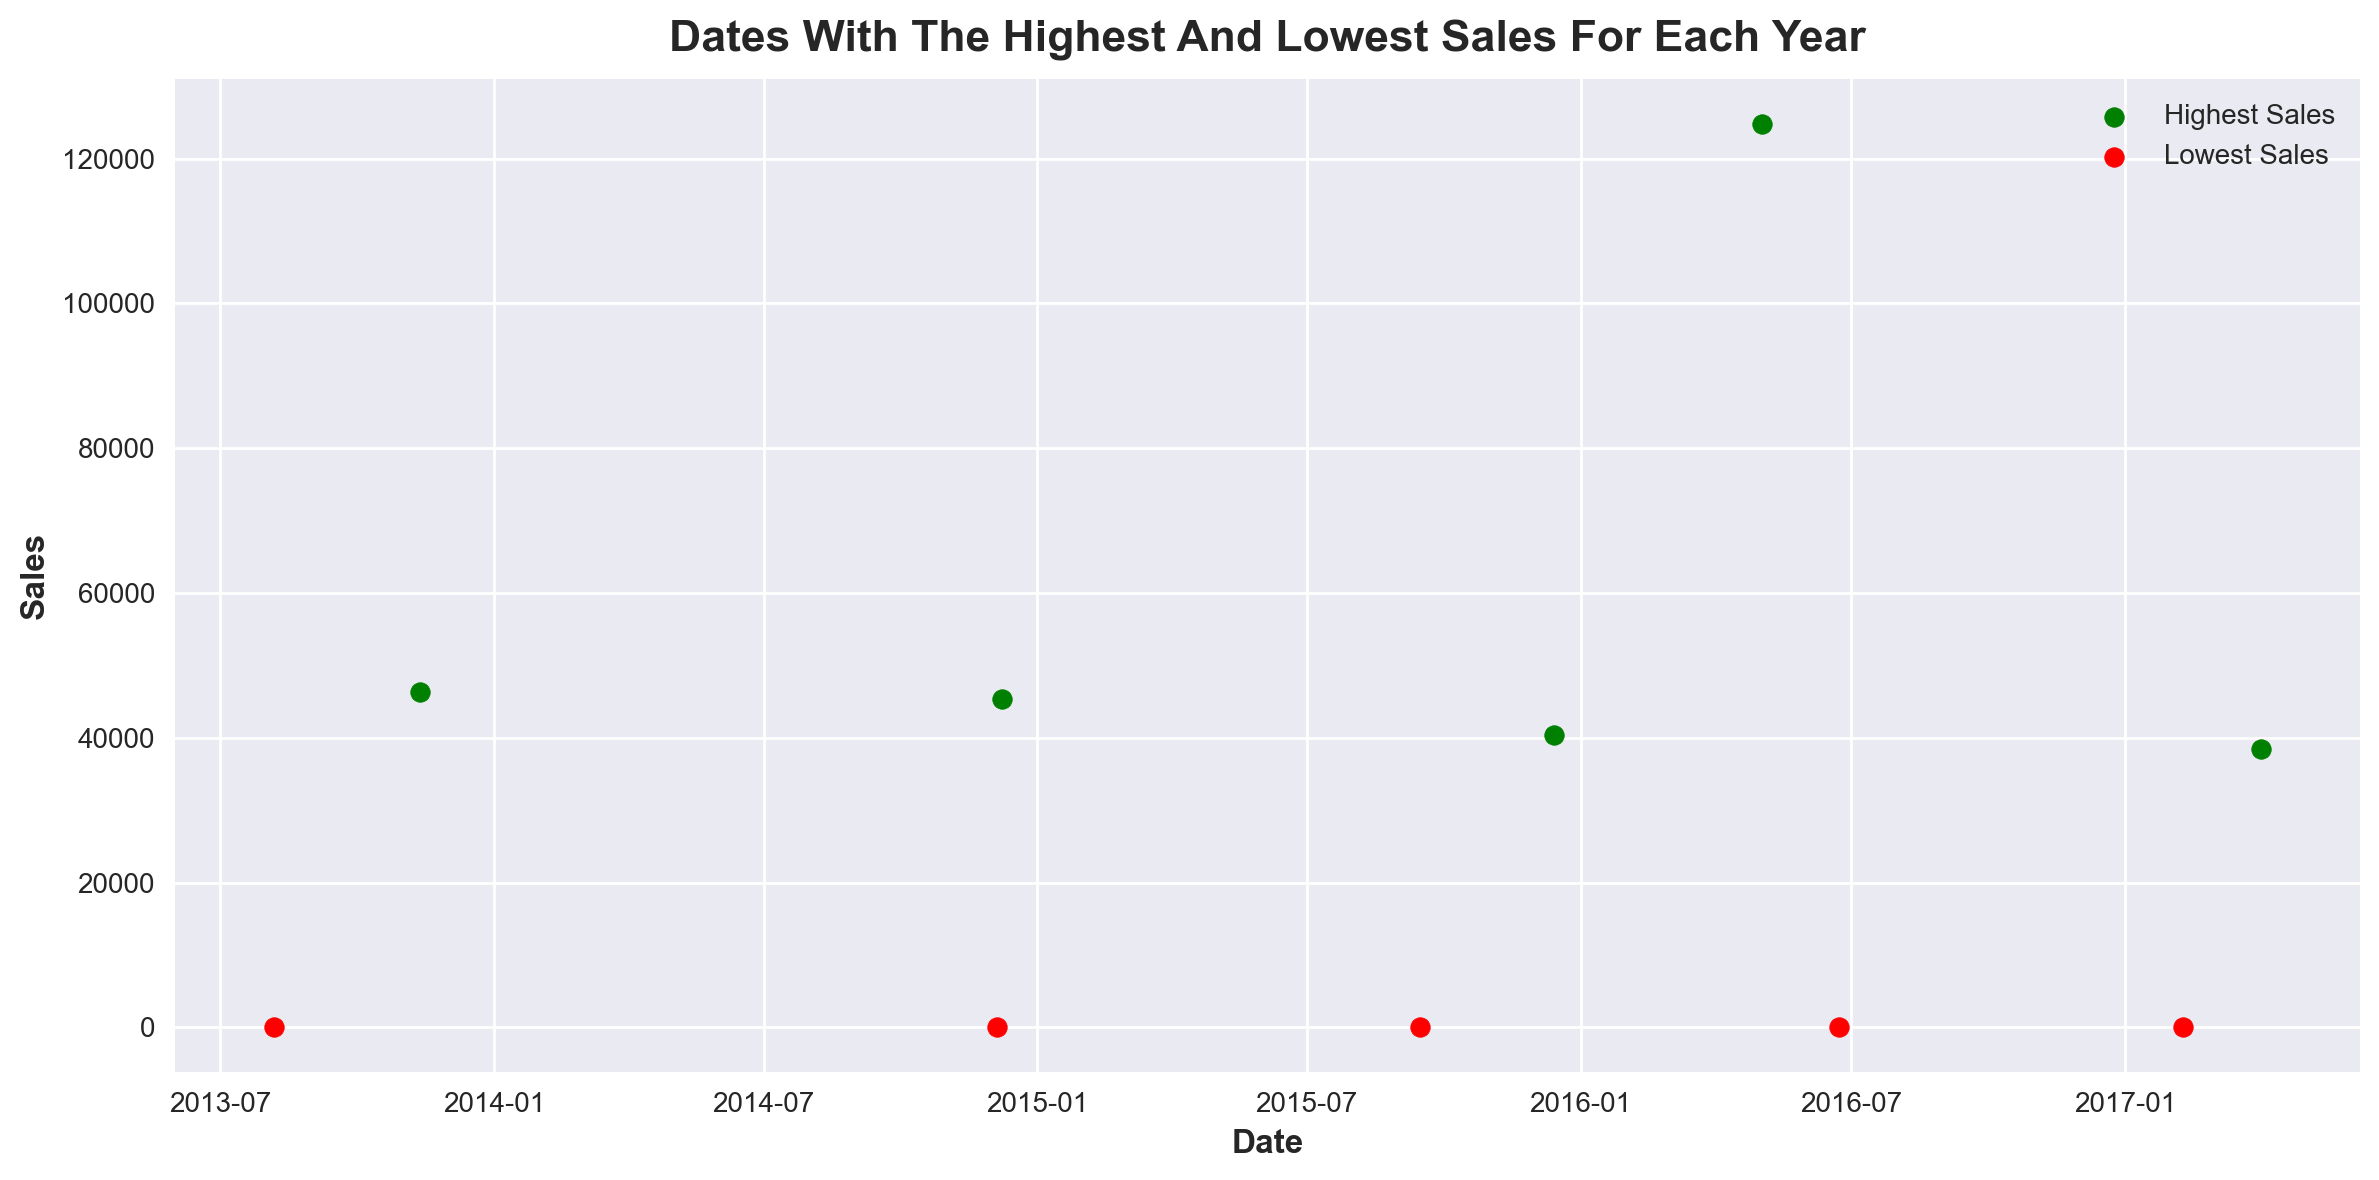

In [57]:
# Visualize the dates that have the lowest and highest sales for each year on a chart

plt.figure(figsize=(12, 6))
plt.scatter(result_df['Highest_Sales_Date'], result_df['Highest_Sales'], color='green', label='Highest Sales', marker='o')
plt.scatter(result_df['Lowest_Sales_Date'], result_df['Lowest_Sales'], color='red', label='Lowest Sales', marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.title('Dates With The Highest And Lowest Sales For Each Year')
plt.show()

### Question 3

Did the earthquake impact sales?

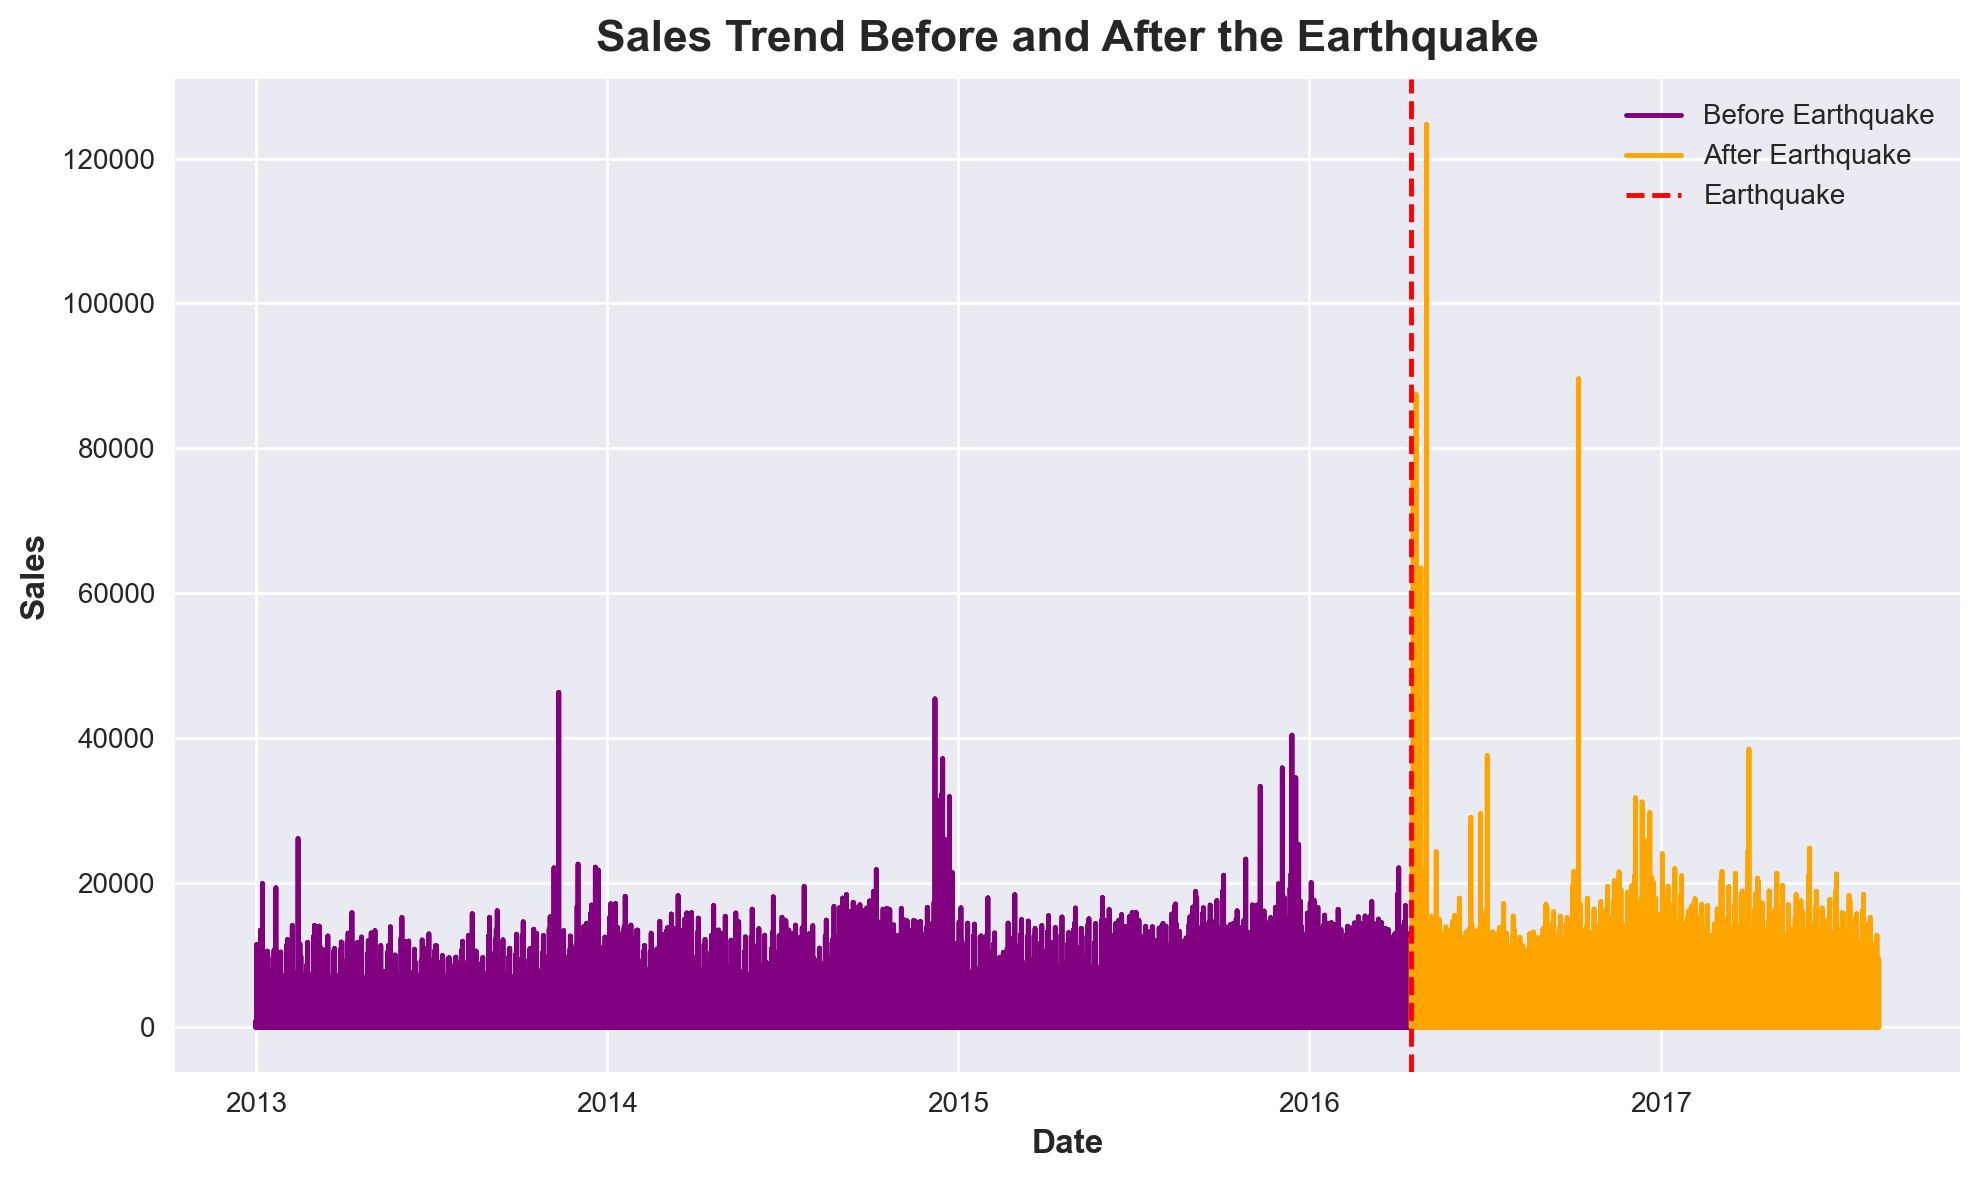

<Figure size 1100x400 with 0 Axes>

In [61]:
# Convert 'date' from index to a regular column
train_data.reset_index(inplace=True)

# Filter the data for the period before and after the earthquake
before_earthquake_df = train_data[train_data['date'] < '2016-04-16']
after_earthquake_df = train_data[train_data['date'] >= '2016-04-16']

# Visualize the impact of the earthquake on sales
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_df['date'], before_earthquake_df['sales'], color='purple', label='Before Earthquake')
plt.plot(after_earthquake_df['date'], after_earthquake_df['sales'], color='orange', label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()

# Save the plot as an image file
plt.savefig('Images/Sales_Trend_Before_and_After_the_Earthquake.png')

# Revert 'date' back to an index
train_data.set_index('date', inplace=True)

The date of the earthquake is shown with the red dash line. As observed on the chat, there was a huge increase in sales immediately after the earthquake. This could be because people needed to stock up food stuffs to be able to stay indoors after the earthquake. Another reason could be that hospitals and emergency corporations needed to buy up materials to cater for the earthquake victims.

Therefore, it is clear that the earthquake impacted sales.

### Question 4

Are certain groups of stores making more sales than others? (Cluster, city, state, type)

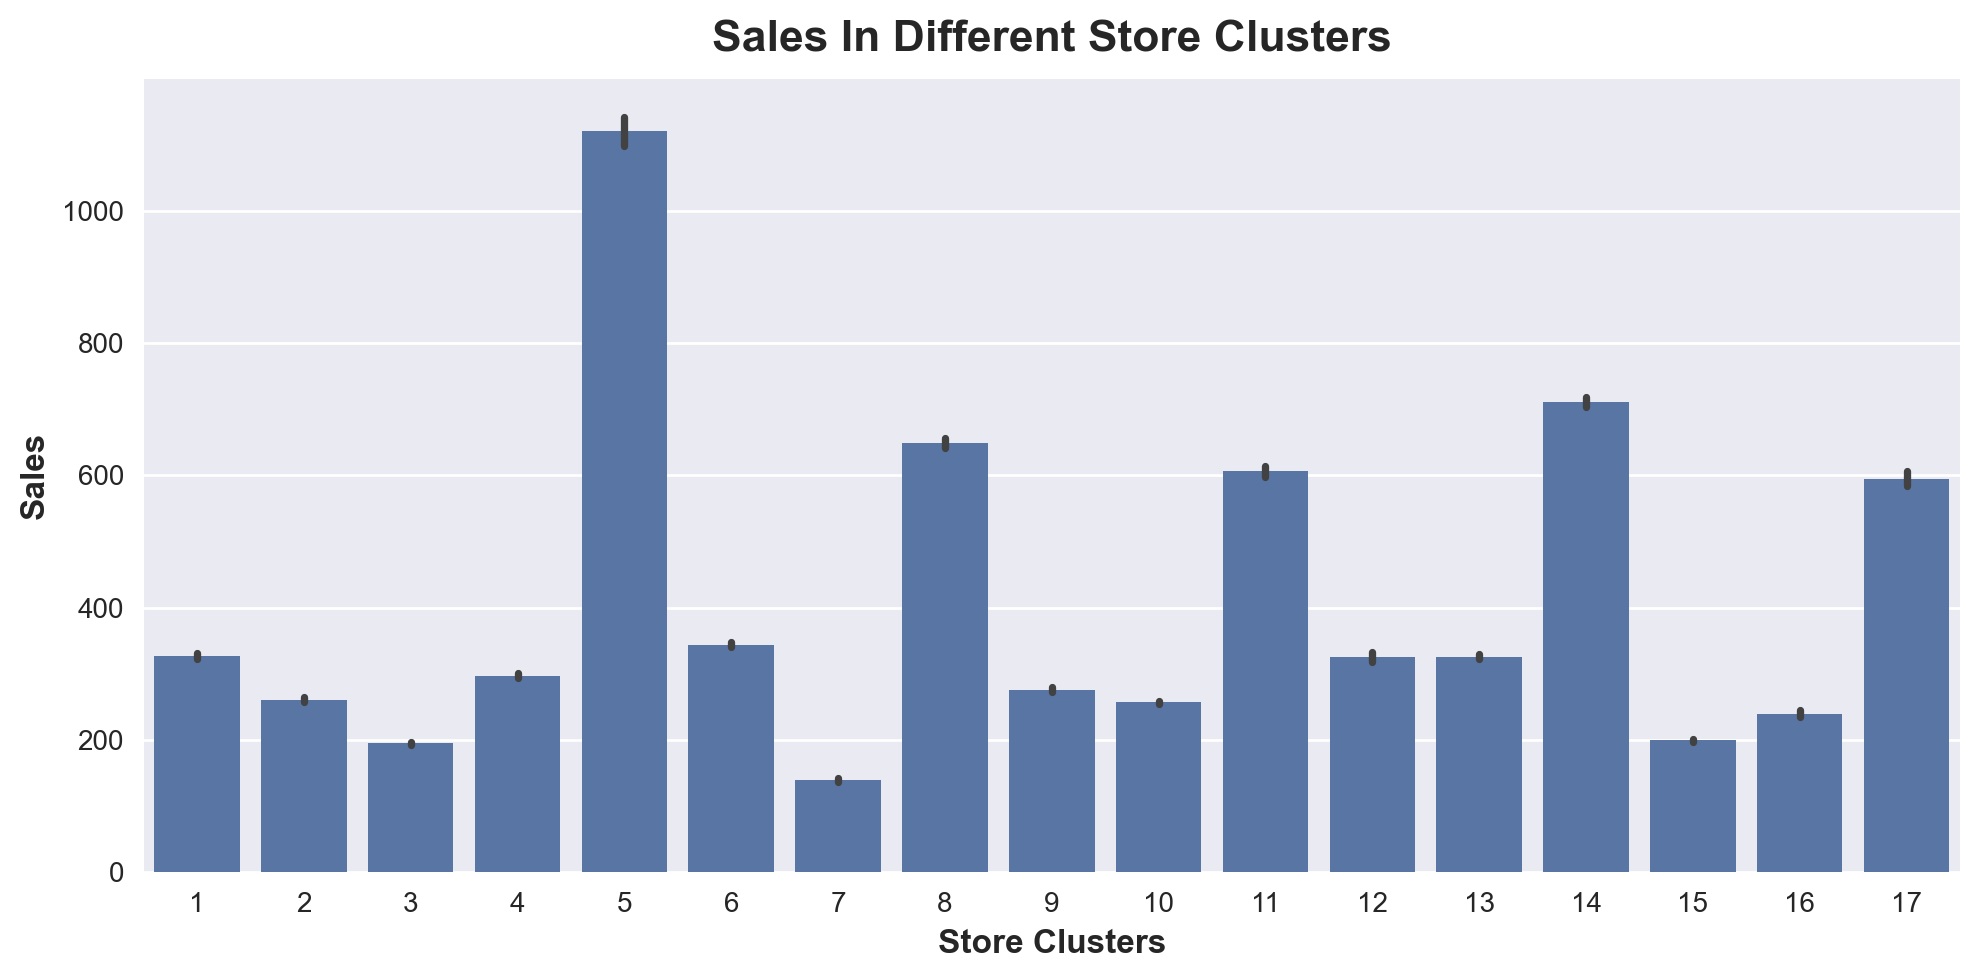

In [64]:
# Compare the sales in the different store clusters

plt.figure(figsize=(10,5))
sns.barplot(x='cluster', y='sales', data=train_data)
plt.title('Sales In Different Store Clusters')
plt.xlabel('Store Clusters')
plt.ylabel('Sales')
plt.show()

The plot above shows that stores in cluster 5 are making more sales than the stores in other clusters, followed by stores in cluster 14.

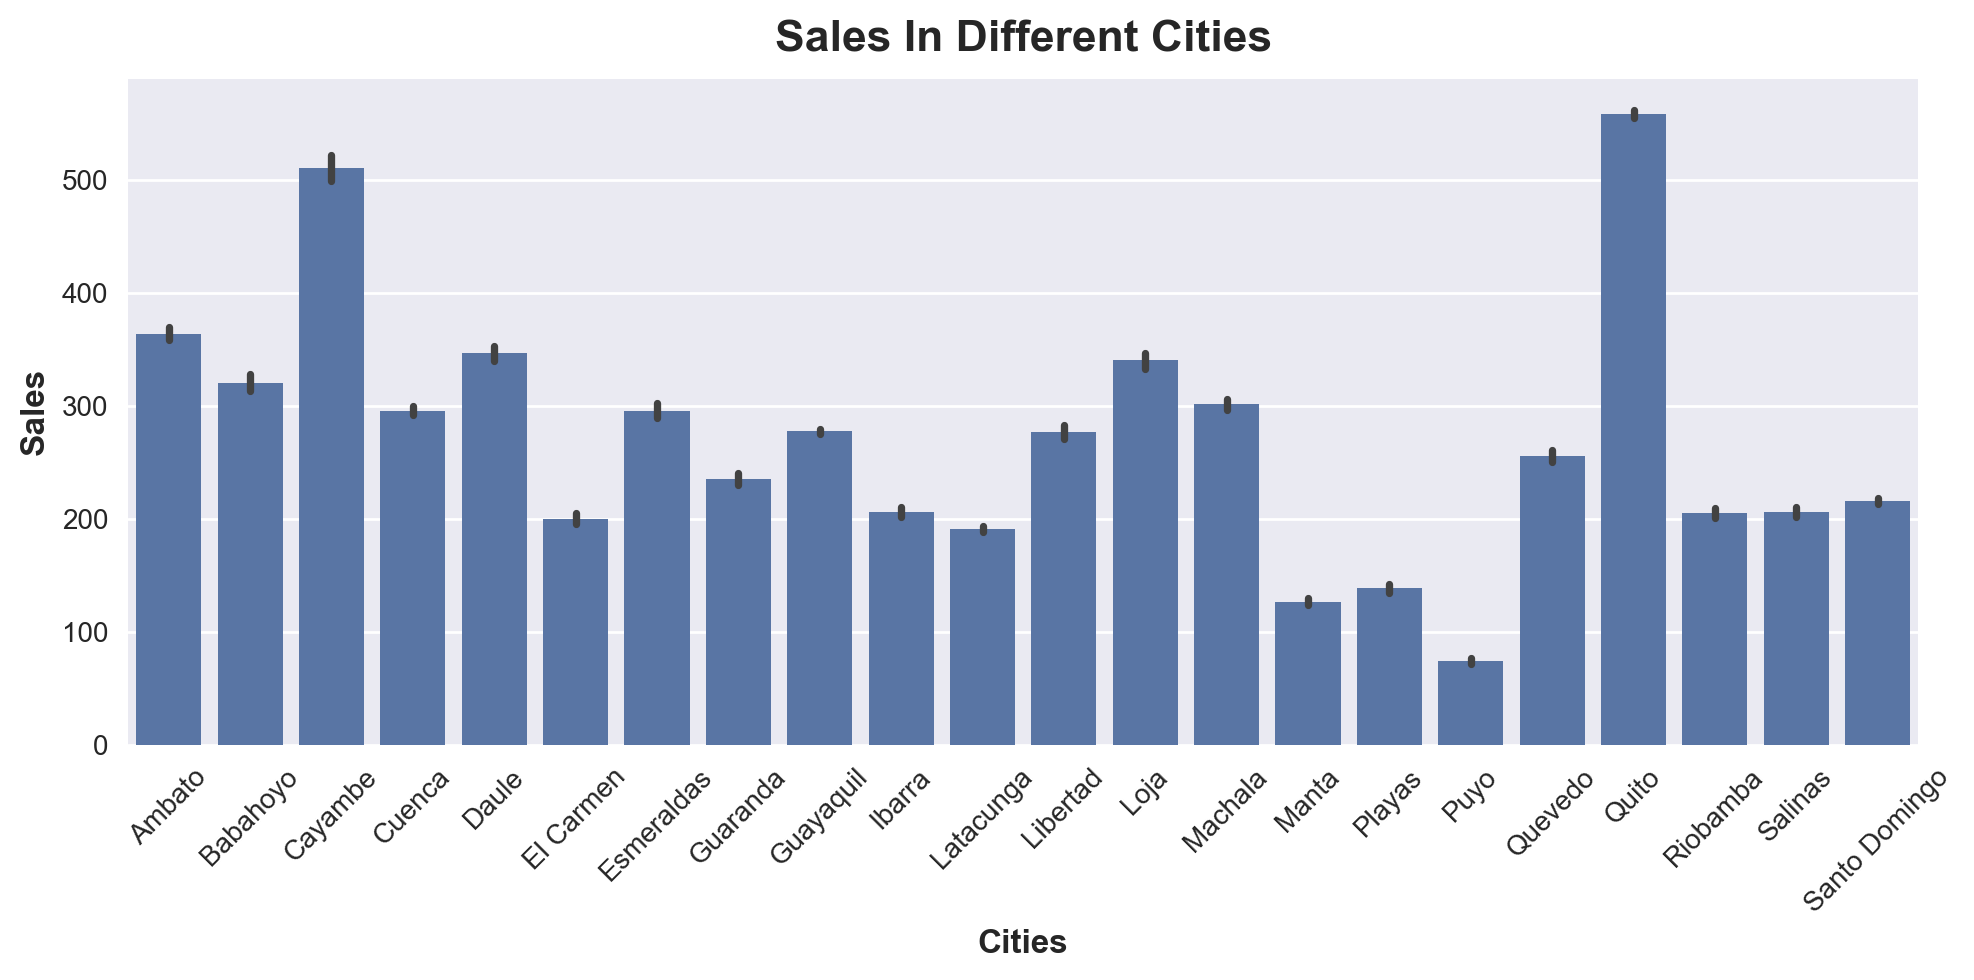

In [65]:
# Compare the sales in different cities

plt.figure(figsize=(10,5))
sns.barplot(x='city', y='sales', data=train_data)
plt.title('Sales In Different Cities')
plt.xlabel('Cities')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

The plot above shows that stores in Quito are making more sales than stores in other cities, followed by stores in Cayambe.

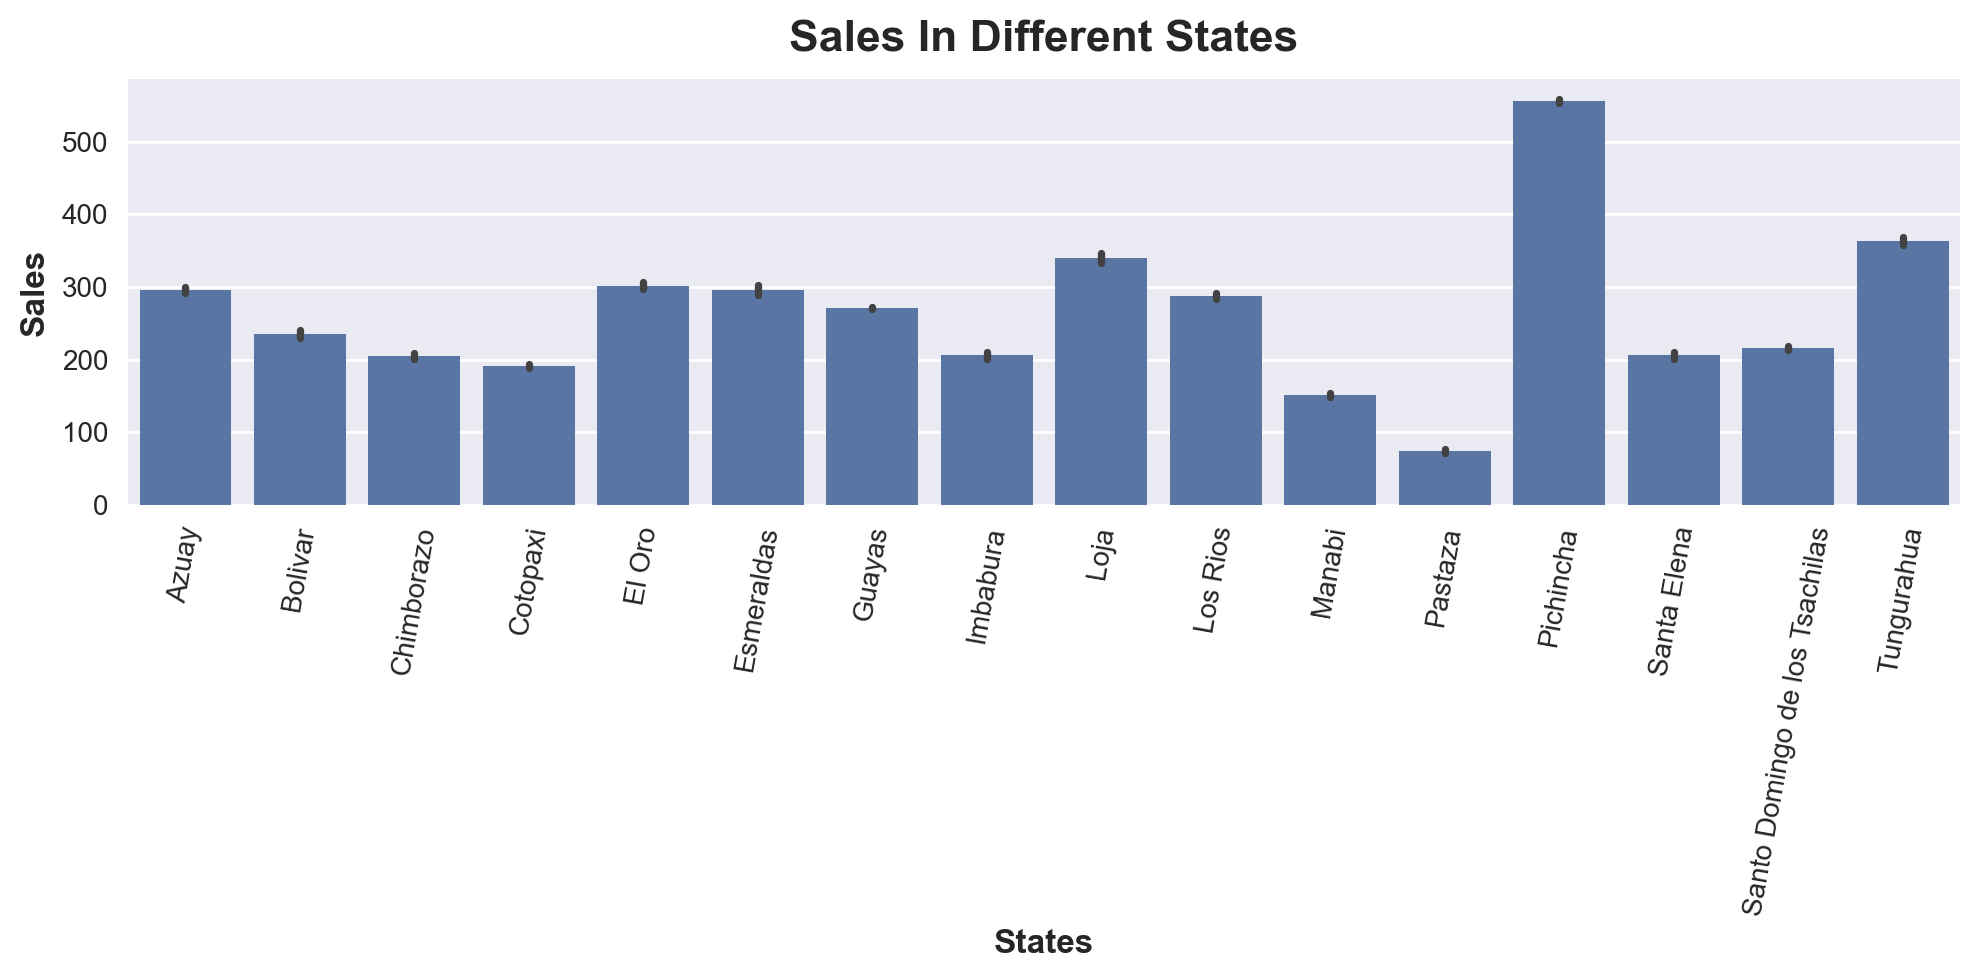

In [66]:
# Compare the sales in different states

plt.figure(figsize=(10,5))
sns.barplot(x='state', y='sales', data=train_data)
plt.title('Sales In Different States')
plt.xlabel('States')
plt.ylabel('Sales')
plt.xticks(rotation = 80)
plt.show()

The plot above shows that stores in Pichincha are making more sales than stores in other states, followed by stores in Tungurahua.

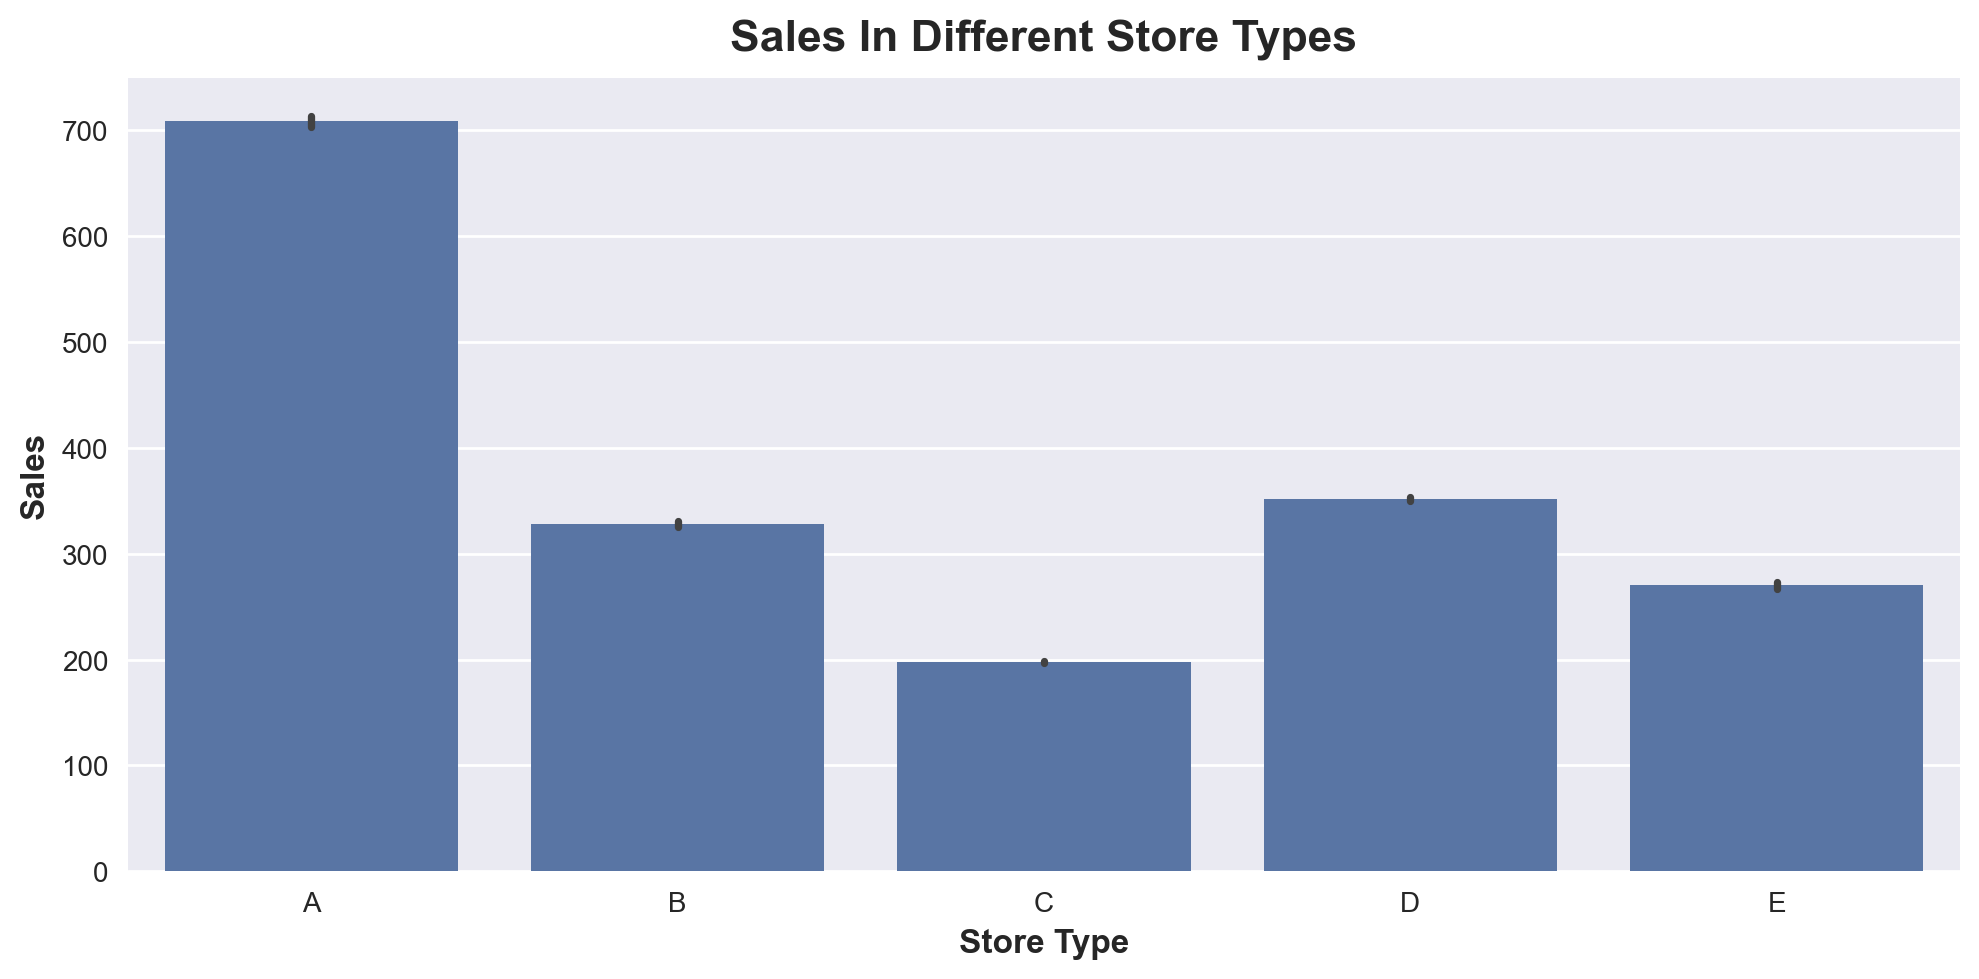

In [67]:
# Compare the sales in different store types

store_types = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales', data=train_data, order=store_types)
plt.title('Sales In Different Store Types')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

The plot above shows that stores in Store type A are making more sales than stores in other store types, followed by stores in Store type D.

In summary, there are groups of stores across the clusters, cities, states, and store types that are making more sales than others.

### Question 5

Are sales affected by promotions, oil prices and holidays?

##### Impact of promotions on sales

Text(0, 0.5, 'Sales')

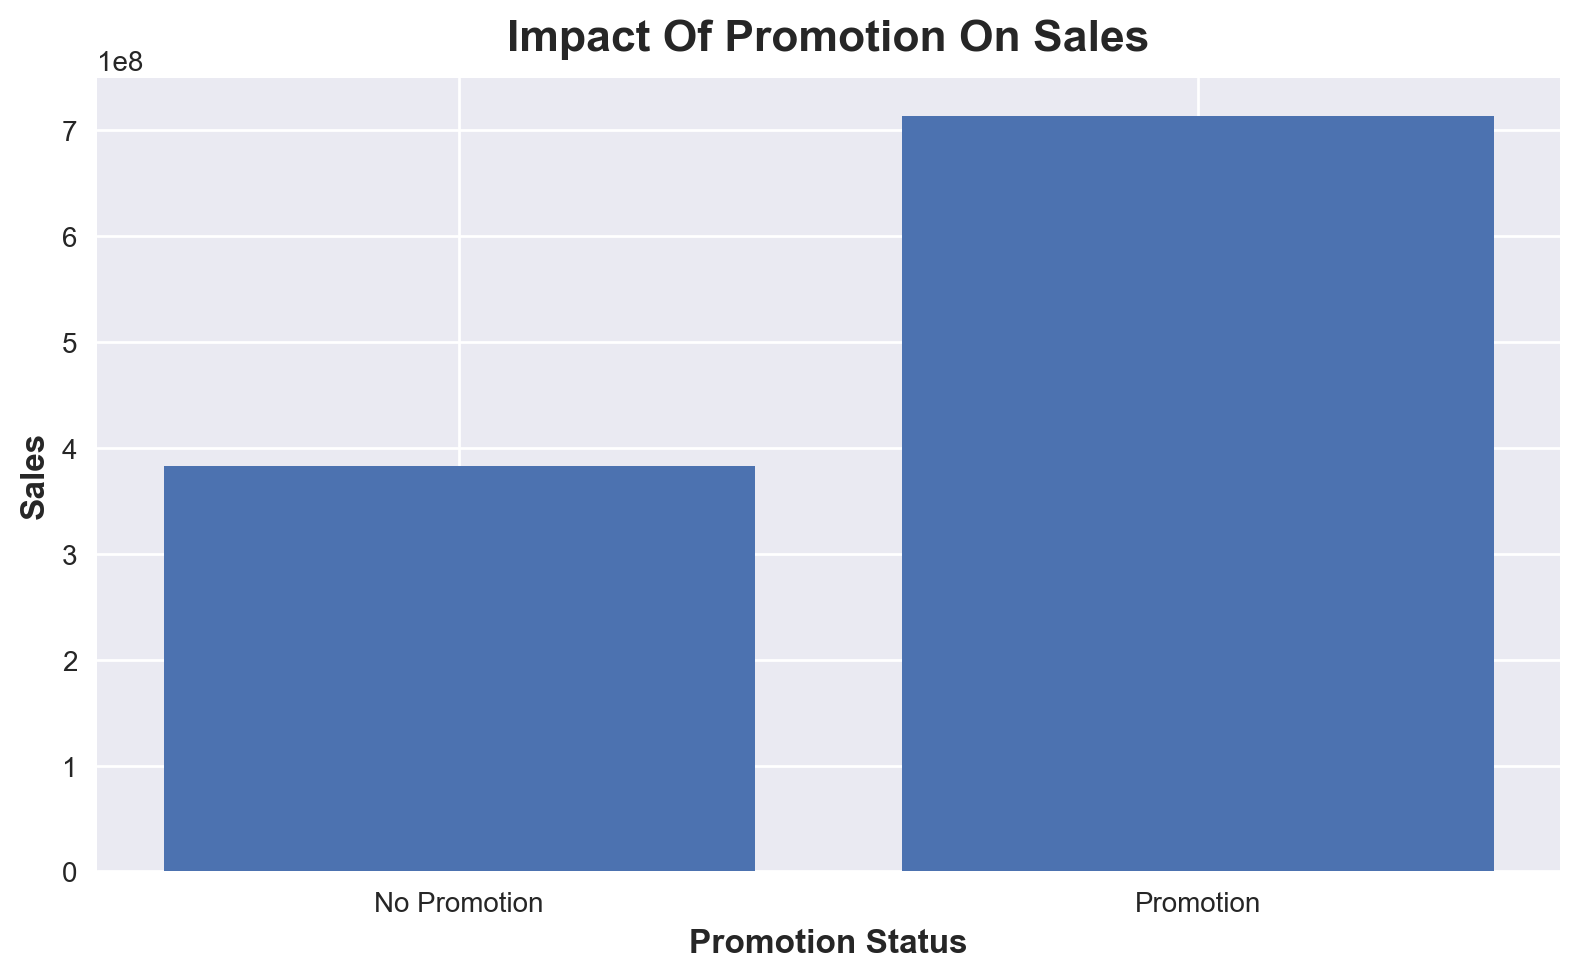

In [69]:
# Identify families with at least one item on promotion and families with no item on promotion
train_data['onpromotion'] = train_data['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = train_data.groupby(['onpromotion'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.onpromotion, x.sales)
plt.title('Impact Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')

The plot above shows that sales are affected by promotion. Product families with items on promotion are being sold more than product families with no item on promotion. As a result, we conclude that sales were affected by promotions.

##### Impact of oil prices on sales

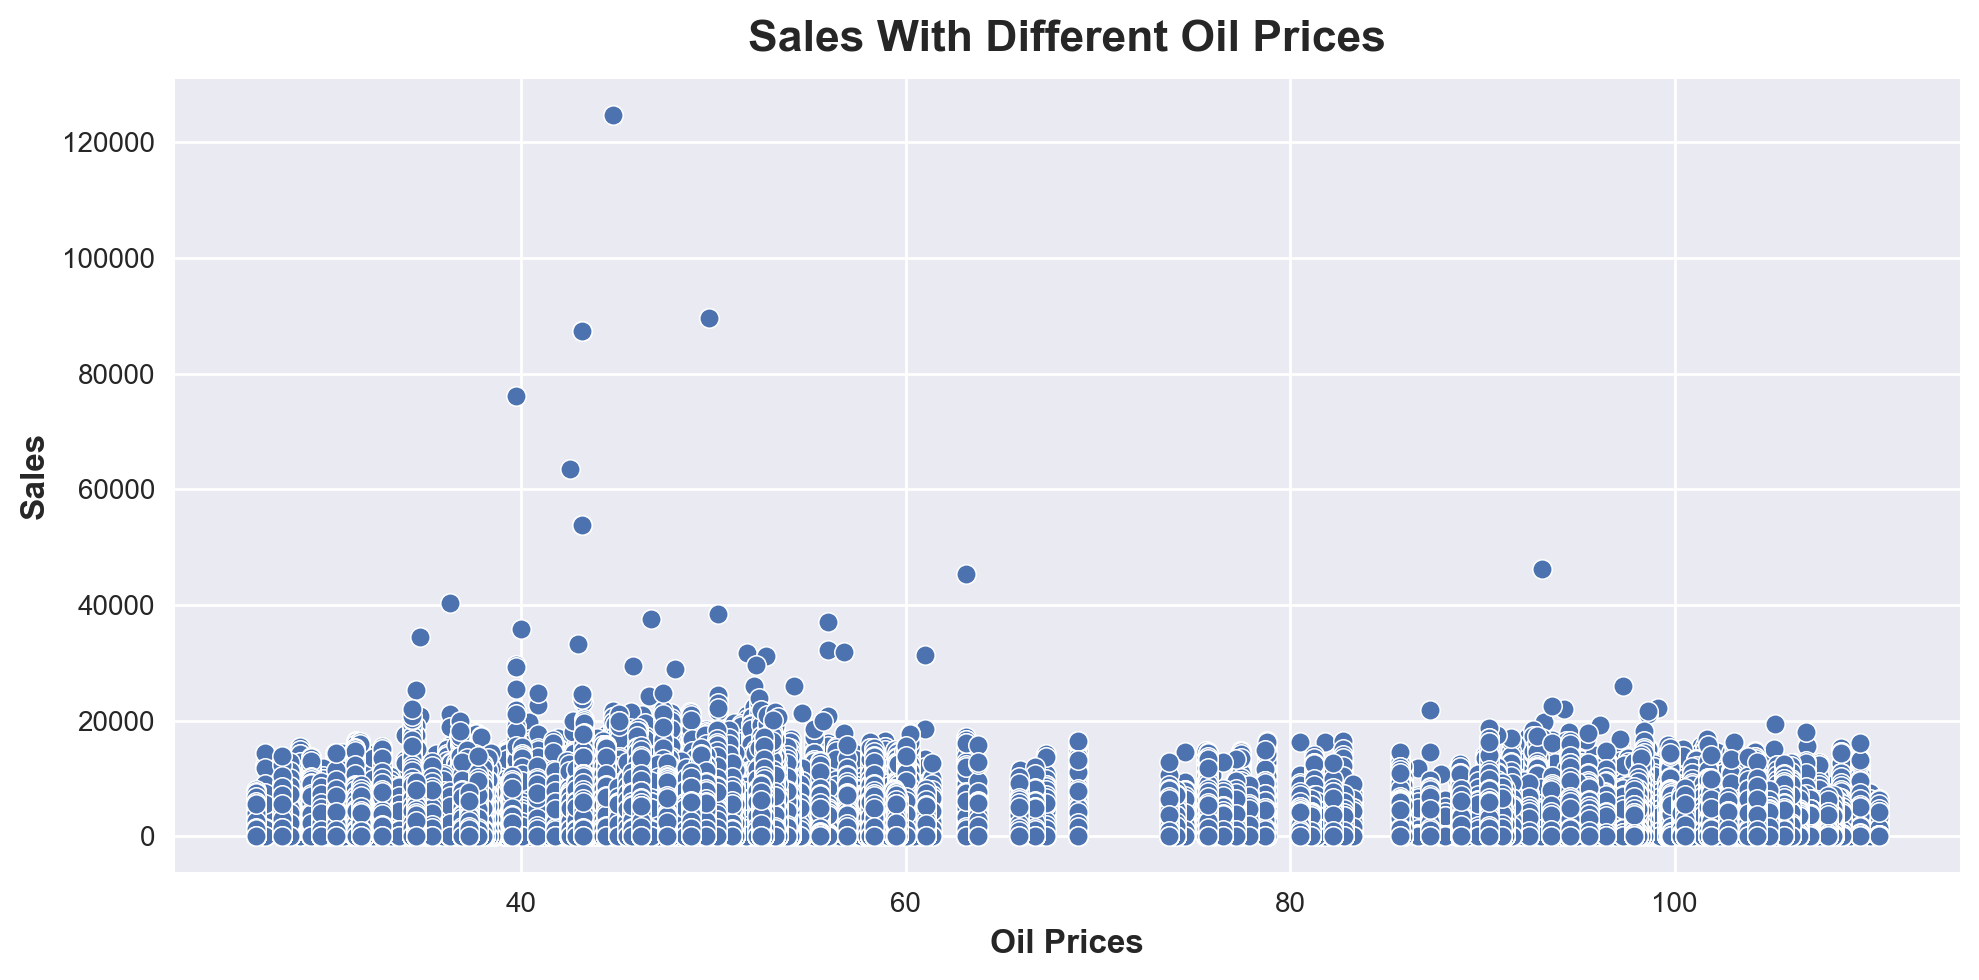

In [71]:
# Compare the sales with different oil prices

plt.figure(figsize=(10,5))
sns.scatterplot(x='oil_price', y='sales', data=train_data)
plt.title('Sales With Different Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

The plot above shows that sales are affected by the oil prices. As shown, there are more number of sales at lower oil prices than at higher oil prices. The outliers shown represent occasions where huge volumes of sales occured. These huge volume trades occured more frequently at lower oil prices than at higher oil prices. As a result of these, we conclude that sales were affected by oil prices.

##### Impact of holidays on sales

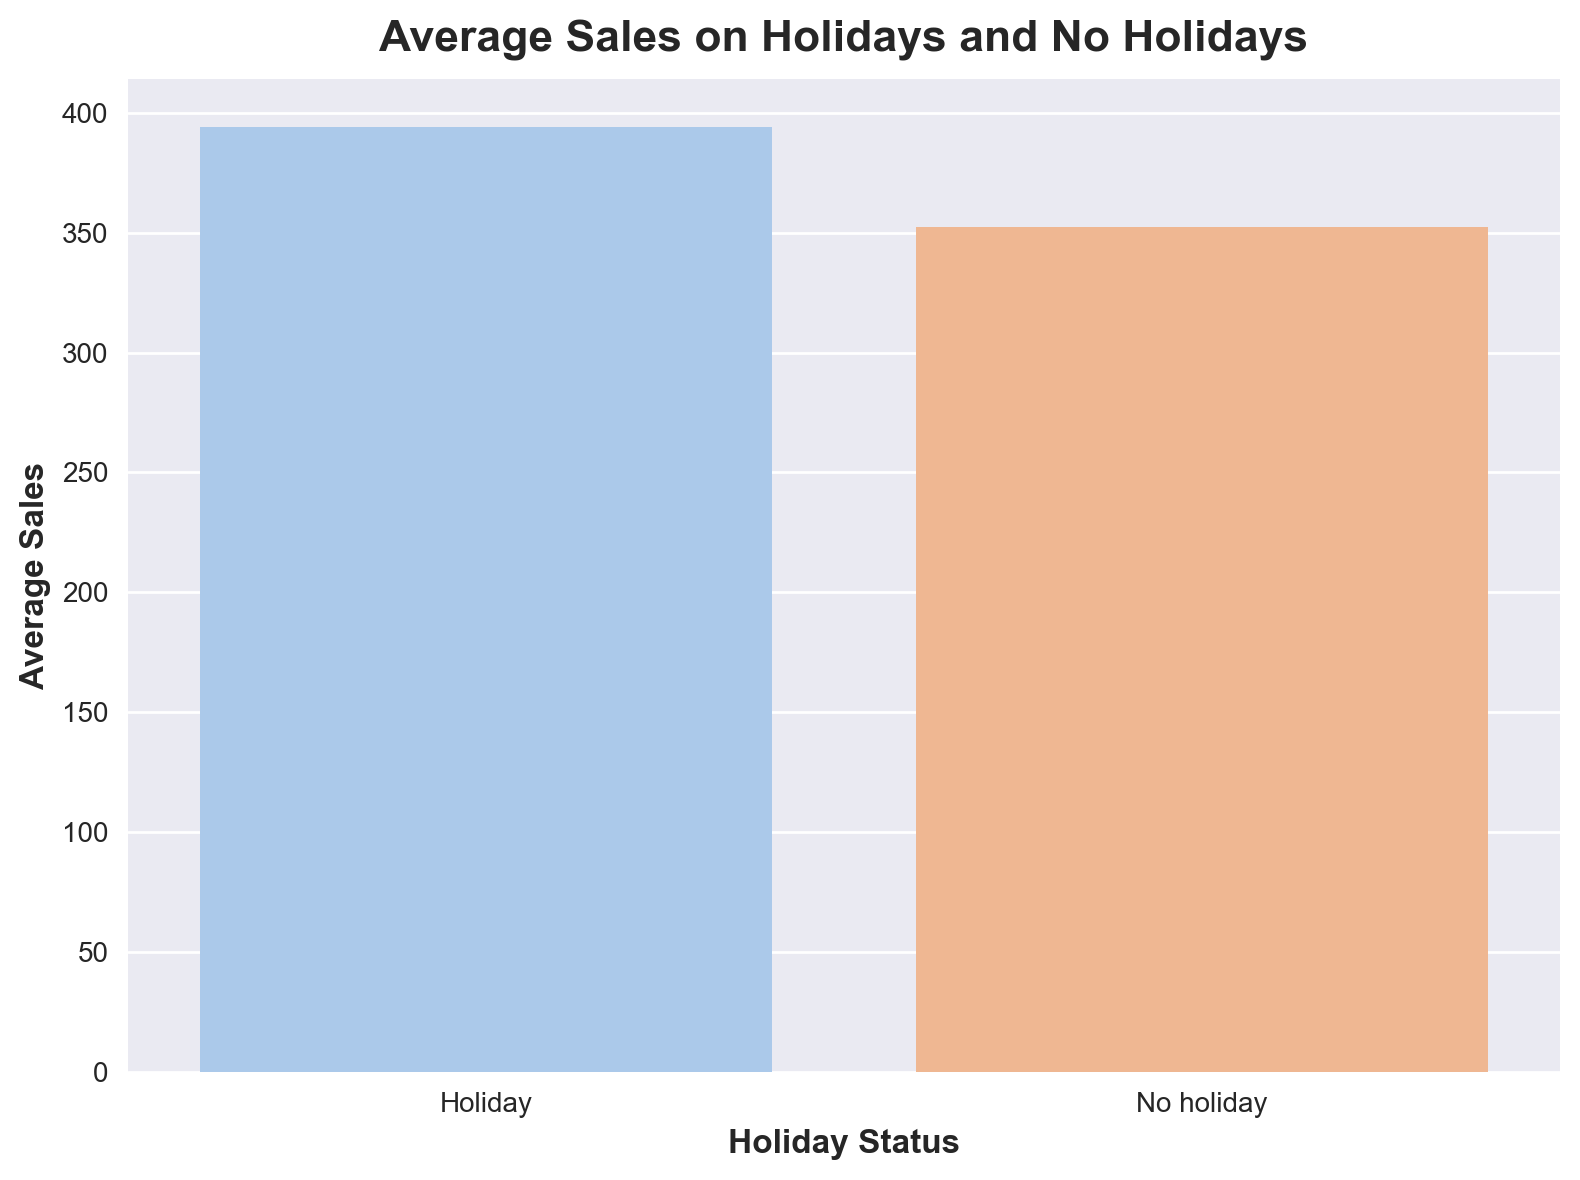

In [73]:
# Group the data by 'holiday_status' and calculate the average sales for each category
average_sales_by_holiday_status = train_data.groupby('holiday_status')['sales'].mean().reset_index()

# Plot the average sales for holidays and no holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='holiday_status', y='sales', data=average_sales_by_holiday_status, palette='pastel')
plt.xlabel('Holiday Status')
plt.ylabel('Average Sales')
plt.title('Average Sales on Holidays and No Holidays')
plt.show()

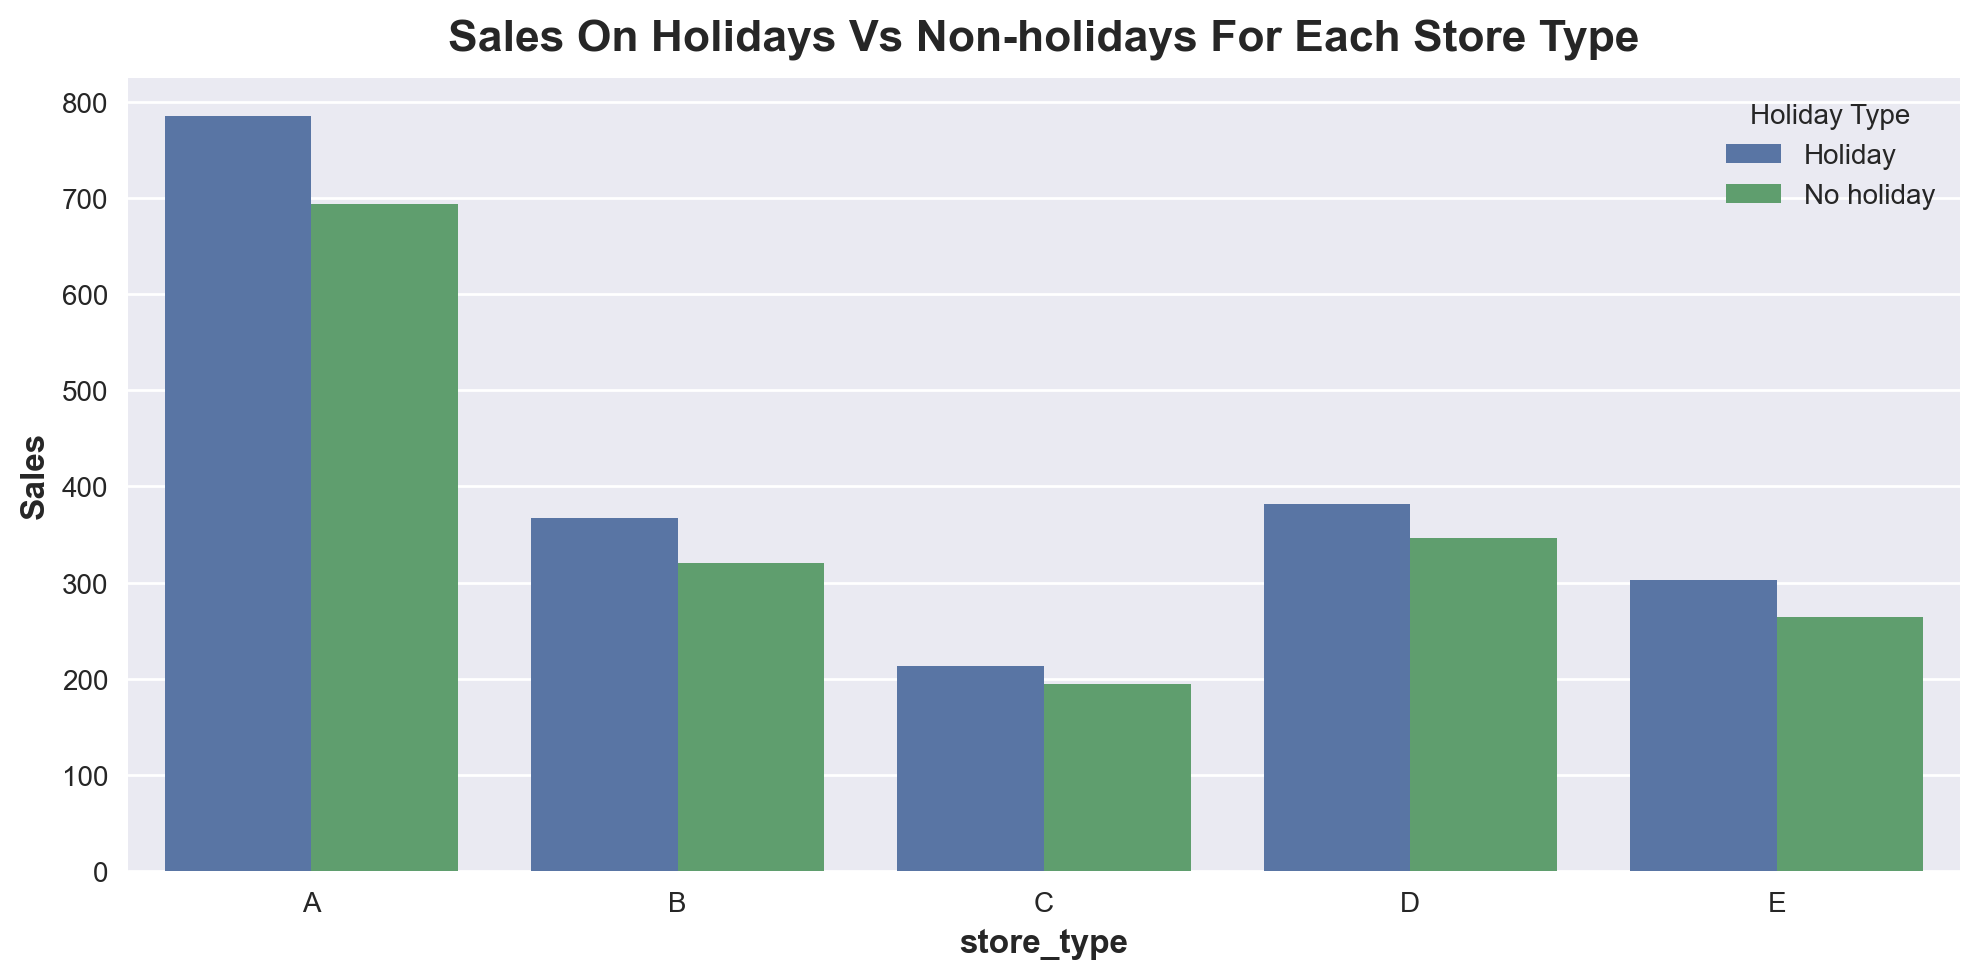

In [75]:
# Compare the sales on holidays with sales on non-holidays for the different store types

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', hue='holiday_status', y='sales', data=train_data, ci=None, order=store_types)
plt.title('Sales On Holidays Vs Non-holidays For Each Store Type')
plt.ylabel('Sales')
plt.legend(title='Holiday Type')
plt.show()

In the first plot above, there are higher sales on holidays than no holidays. This is because more people are free to go out for shopping on holidays than no holidays when they have to be at work or school.

In the second plot above, there are more sales on holidays than no holidays across all the store types. 

For these reasons, we conclude that sales were affected by holidays.

### Question 6

What analysis can we get from the date and its extractable features?

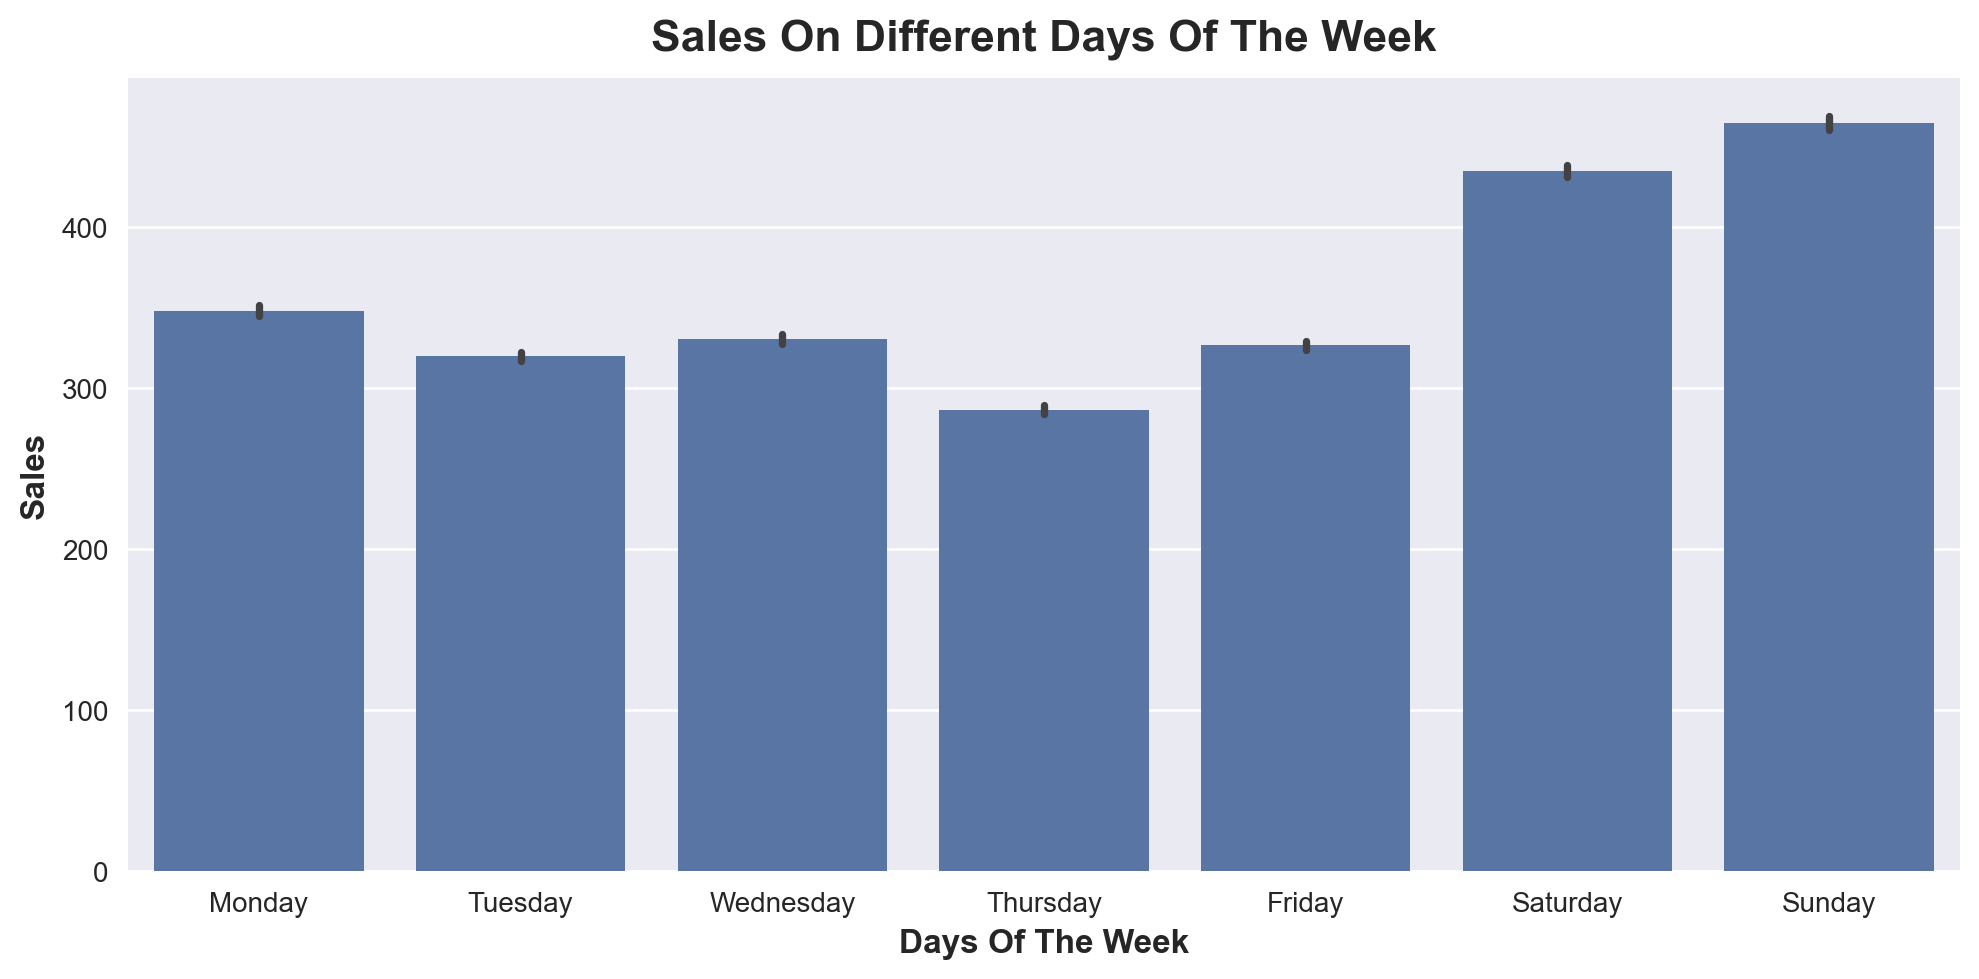

In [76]:
# From the date and its extractable features, the average sales on different days of the week can be analyzed
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x='dayname', y='sales', data=train_data, order=days)
plt.title('Sales On Different Days Of The Week')
plt.xlabel('Days Of The Week')
plt.ylabel('Sales')
plt.show()

From the date and its extractable features, we can analyze the sales on the different days of the week as shown in the plot. There are more sales during the weekends with peak sales on Sundays, followed by Saturdays. This could be because generally many people do not go to work (or only work few hours) during the weekends, and thus would have more time to shop during weeekends than weekdays. The least sales were on Thursdays.

### Question 7

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. It is less sensitive to outliers but generally larger than RMSE and MSE.

MSE (Mean Squared Error) measures the average squared difference between predicted and actual values. It gives more weight to large errors, making it sensitive to outliers.

RMSE (Root Mean Squared Error) is the square root of MSE and has the same sensitivity to outliers as MSE but is more interpretable.

RMSLE (Root Mean Squared Logarithmic Error) is useful when relative errors matter more than absolute errors and is less sensitive to outliers in the target variable.

MAE is generally greater than RMSE and MSE because it does not penalize larger errors as heavily as squared-error metrics.

### Question 8

What is the total sales made each year by the corporation?

In [80]:
# Group by year and sum the sales for each year

total_sales_per_year = train_data.groupby(['year'], as_index=False).agg({'sales':'sum'})
total_sales_per_year

,year,sales
0,2013,1.424880e+08
1,2014,2.130044e+08
2,2015,2.438321e+08
3,2016,2.991820e+08
4,2017,1.980683e+08


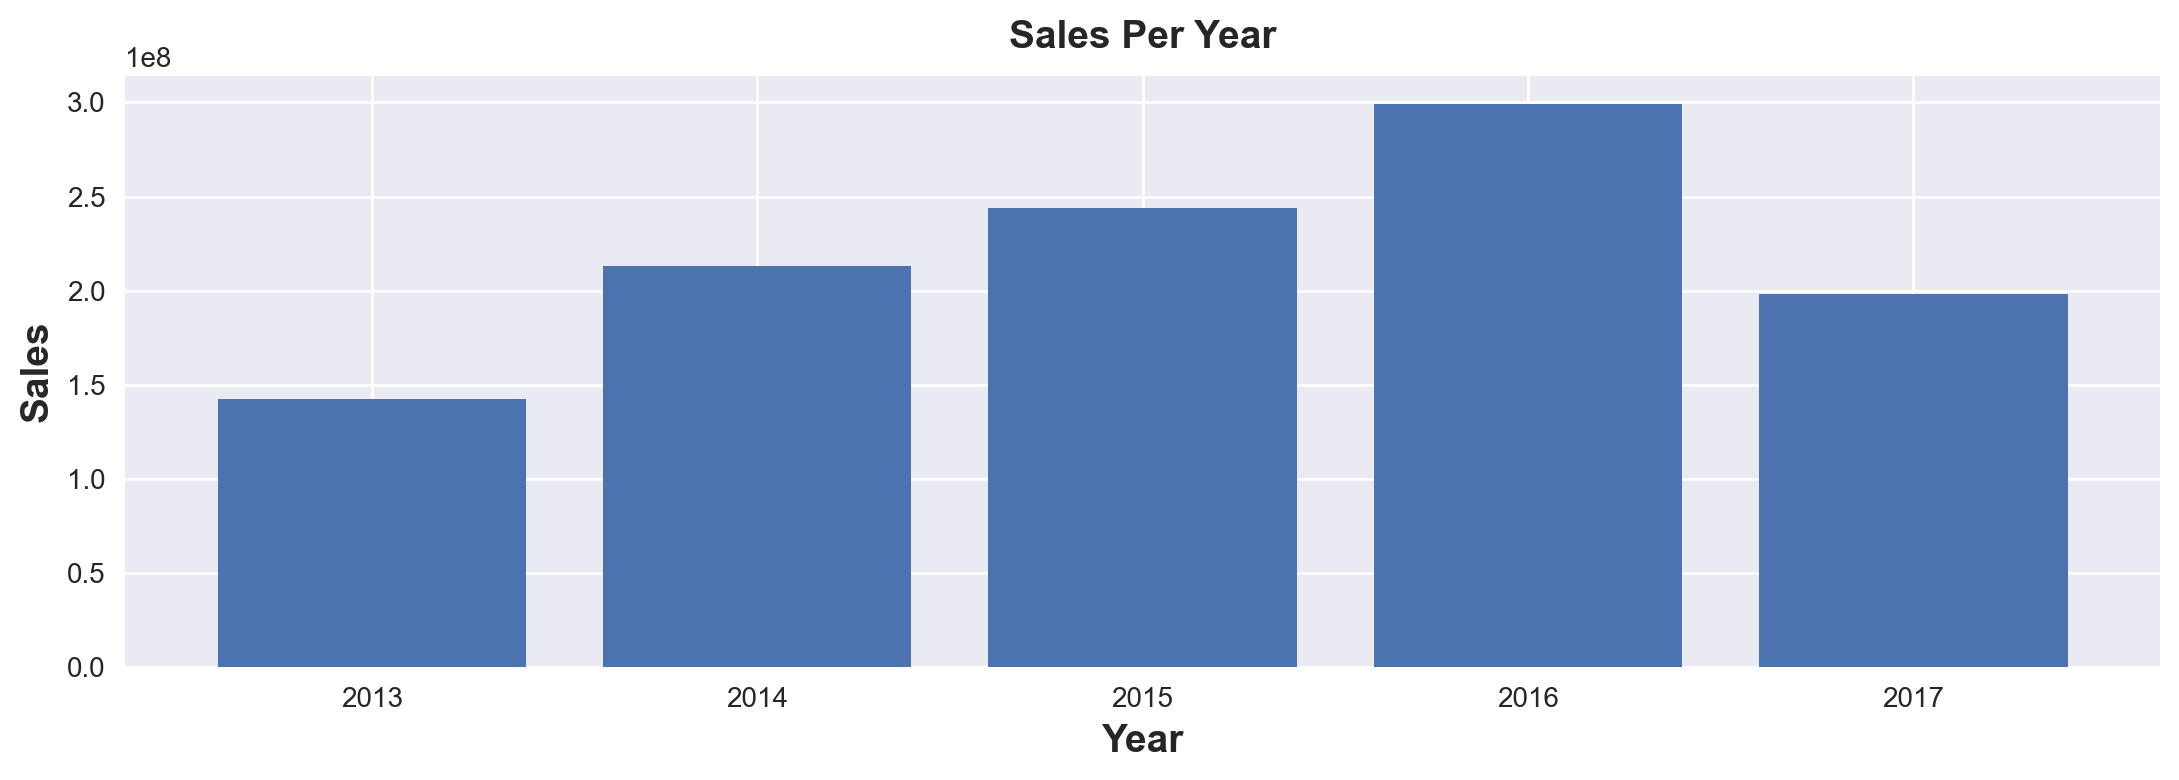

In [81]:
# Plot the total sales made each year

plt.bar(total_sales_per_year.year, sales_per_year.sales)
plt.title('Sales Per Year',fontsize=14)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

The plot above displays the total sales made each year by Corporation Favorita. The plot also shows that Corporation Favorita made it's lowest sales in 2013 and its highest sales in 2016.

Recall that the earthquake occured on 16th April, 2016 (2016-04-16), and it led to a huge increase in sales. This increase in sales as a result of the earthquake in 2016 contributed enormously to the sales of Corporation Favorita. Corporation Favorita recorded it's highest sales in 2016 across the years captured in the dataset.

# Feature Engineering

Feature engineering processes include feature selection, data splitting, feature encoding, feature scaling etc. These processes are required to prepare the dataset for modelling.

In [ ]:
# Create a copy of the train dataset then carry out feature engineering on it

train_df = train_data.copy()

### Feature Selection

In [ ]:
# Display random sample of 10 rows to see the contents of the columns

train_df.sample(10, random_state = 42)

In [ ]:
# Display all the columns of the dataset

train_df.columns

In [98]:
# Drop some columns and display the dataset
columns_to_drop = ['store_nbr', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'city', 'store_type', 'cluster', 'month',
                   'dayofmonth', 'dayofweek', 'dayname', 'state', 'holiday_status']
train_df = train_df.drop(columns_to_drop, axis=1)

train_df.head()

,family,sales,onpromotion,transactions,oil_price
date,,,,,
2013-01-01,AUTOMOTIVE,0.0,No Promotion,0.0,93.139999
2013-01-01,BABY CARE,0.0,No Promotion,0.0,93.139999
2013-01-01,BEAUTY,0.0,No Promotion,0.0,93.139999
2013-01-01,BEVERAGES,0.0,No Promotion,0.0,93.139999
2013-01-01,BOOKS,0.0,No Promotion,0.0,93.139999


### Data Splitting

The dataset will be splitted to training and validation sets using the time-based split. This will be done based on the years.

In [84]:
# List the years in the dataset

train_df['year'].unique()

array([2013, 2014, 2015, 2016, 2017])

In [85]:
# Establish the years for the training set and validation set
train_years = [2013, 2014, 2015, 2016]
val_year = [2017]

# Obtain the training set and validation set
train_set = train_df.loc[(train_df['year'].isin(train_years) & train_df['year'].isin(train_years))]
val_set = train_df.loc[(train_df['year'].isin(val_year) & train_df['year'].isin(val_year))]

# Print the shape of the training set and validation set
train_set.shape, val_set.shape

((2642706, 8), (411642, 8))

In [86]:
# Check the datatypes of the columns of the training set

train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2642706 entries, 2013-01-01 to 2016-12-31
Data columns (total 8 columns):
 #   Column          Dtype   
---  ------          -----   
 0   family          object  
 1   sales           float64 
 2   onpromotion     object  
 3   transactions    float64 
 4   oil_price       float64 
 5   state           category
 6   holiday_status  object  
 7   year            int32   
dtypes: category(1), float64(3), int32(1), object(3)
memory usage: 153.7+ MB


In [87]:
# Extract the original index column for later use
train_index = train_set.index
val_index = val_set.index

# Obtain the categorical columns to encode and numerical columns to scale
cat_columns_to_encode = ['family', 'onpromotion']
num_columns_to_scale = ['transactions', 'oil_price', 'sales']

# Create seperate DataFrames for categorical columns and numerical columns of training set
train_set_cat_df = train_set[cat_columns_to_encode]
train_set_num_df = train_set[num_columns_to_scale]

# Create seperate DataFrames for categorical columns and numerical columns of validation set
val_set_cat_df = val_set[cat_columns_to_encode]
val_set_num_df = val_set[num_columns_to_scale]

### Feature Encoding

In [88]:
# Create an encoder object using OneHotEncoder.
# Set sparse=False for dense output and drop='first' to avoid multicollinearity

encoder = OneHotEncoder(sparse=False, drop='first')

In [89]:
# Use OneHotEncoder to encode the categorical columns of the training set
encoder.fit(train_set_cat_df)
train_set_cat_encoded = encoder.transform(train_set_cat_df).tolist()
train_set_cat_encoded_df = pd.DataFrame(train_set_cat_encoded, columns=encoder.get_feature_names_out(), index=train_index)

# View the encoded columns of the training set
train_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_status_No holiday
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [90]:
# Use OneHotEncoder to encode the categorical columns of the validation set
encoder.fit(val_set_cat_df)
val_set_cat_encoded = encoder.transform(val_set_cat_df).tolist()
val_set_cat_encoded_df = pd.DataFrame(val_set_cat_encoded, columns=encoder.get_feature_names_out(), index=val_index)

# View the encoded columns of the validation set
val_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_status_No holiday
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Feature Scaling

MinMaxScaler will be used for feature scaling as it is suitable for time series data because it preserves the relative differences between data points and maintains the temporal information.

In [91]:
# Create a scaler object using MinMaxScaler

scaler = MinMaxScaler()

In [92]:
# Use StandardScaler to scale the numerical columns of the training set
scaler.fit(train_set_num_df)
train_set_num_scaled = scaler.transform(train_set_num_df).tolist()
train_set_num_scaled_df = pd.DataFrame(train_set_num_scaled, columns=scaler.get_feature_names_out(), index=train_index)

# View the scaled columns of the training set
train_set_num_scaled_df.head()

,transactions,oil_price,sales
date,,,
2013-01-01,0.0,0.792965,0.0
2013-01-01,0.0,0.792965,0.0
2013-01-01,0.0,0.792965,0.0
2013-01-01,0.0,0.792965,0.0
2013-01-01,0.0,0.792965,0.0


In [93]:
# Use StandardScaler to scale the numerical columns of the validation set
scaler.fit(val_set_num_df)
val_set_num_scaled = scaler.transform(val_set_num_df).tolist()
val_set_num_scaled_df = pd.DataFrame(val_set_num_scaled, columns=scaler.get_feature_names_out(), index=val_index)

# View the scaled columns of the validation set
val_set_num_scaled_df.head()

,transactions,oil_price,sales
date,,,
2017-01-01,0.0,0.823333,0.0
2017-01-01,0.0,0.823333,0.0
2017-01-01,0.0,0.823333,0.0
2017-01-01,0.0,0.823333,0.0
2017-01-01,0.0,0.823333,0.0


In [94]:
# Combine the encoded and scaled DataFrames to get the final training and validation sets
train_final = pd.concat([train_set_cat_encoded_df, train_set_num_scaled_df], axis=1)
val_final = pd.concat([val_set_cat_encoded_df, val_set_num_scaled_df], axis=1)

# Print the shape of the final training and validation sets
train_final.shape, val_final.shape

((2642706, 52), (411642, 52))

In [95]:
# Display the first five rows of the final training set

train_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_status_No holiday,transactions,oil_price,sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.792965,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.792965,0.0
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.792965,0.0
2013-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.792965,0.0
2013-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.792965,0.0


In [96]:
# Display the first five rows of the final validation set

val_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_status_No holiday,transactions,oil_price,sales
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.823333,0.0
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.823333,0.0
2017-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.823333,0.0
2017-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.823333,0.0
2017-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.823333,0.0


In [ ]:
# Separate the features (X) and the target variable (y) for training and validation sets
X_train = train_final.drop('sales', axis=1)
y_train = train_final['sales']
X_val = val_final.drop('sales', axis=1)
y_val = val_final['sales']

# Replace the elements of y_val with their absolute value in order to eliminate the presence of negative values in the y_val array
y_val = np.abs(y_val)
y_val = y_val.reset_index(drop=True)

# Verify the lengths of the features(X) and the target variable (y) of the final training and validation sets
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_test:", len(X_val))
print("Length of y_test:", len(y_val))

# Modelling

The following models will be trained and evaluated:
1. Linear Regression

2. XGBoost

3. CatBoost

4. AutoRegressive (AR)

5. AutoRegressive Integrated Moving Average (ARIMA)

6. Seasonal AutoRegressive Integrated Moving Average (SARIMA)

In [100]:
# Create an empty DataFrame to store the results of the evaluation metrics of each model

results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MSLE', 'RMSLE'])
results

,Model,MSE,RMSE,MSLE,RMSLE


### Model 1: Linear Regression

In [101]:
# Initialize the model
linear_regression_model = LinearRegression()

# Fit the model
linear_regression_model.fit(X_train, y_train)

# Make predictions on the final validation set
linear_regression_pred = linear_regression_model.predict(X_val)

# Calculate the evaluation metrics
linear_regression_mae = mean_absolute_error(y_val, linear_regression_pred)
linear_regression_mse = mean_squared_error(y_val, linear_regression_pred)
linear_regression_rmse = np.sqrt(linear_regression_mse)
linear_regression_msle = msle_with_non_negative_targets(y_val, linear_regression_pred)
linear_regression_rmsle = np.sqrt(linear_regression_msle)

# Create a dictionary for the evaluation metrics of Linear Regression model
linear_regression_evaluation_metrics = pd.DataFrame({'Model': ['Linear Regression'], 'MAE': [linear_regression_mae],
                                                     'MSE': [linear_regression_mse], 'RMSE': [linear_regression_rmse],
                                                     'MSLE': [linear_regression_msle], 'RMSLE': [linear_regression_rmsle]})

# Add the linear regression evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, linear_regression_evaluation_metrics], ignore_index=True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.000988,0.031436,0.000219,0.014799


### Model 2: XGBoost

In [102]:
# Initialize the model
xgboost_model = XGBRegressor()

# Fit the model
xgboost_model.fit(X_train, y_train)

# Make predictions on the final validation set
xgboost_pred = xgboost_model.predict(X_val)

# Calculate the evaluation metrics
xgboost_mae = mean_absolute_error(y_val, xgboost_pred)
xgboost_mse = mean_squared_error(y_val, xgboost_pred)
xgboost_rmse = np.sqrt(xgboost_mse)
xgboost_msle = msle_with_non_negative_targets(y_val, xgboost_pred)
xgboost_rmsle = np.sqrt(xgboost_msle)

# Create a dictionary for the evaluation metrics of xgboost model
xgboost_evaluation_metrics = pd.DataFrame({'Model': ['XGBoost'], 'MAE': [xgboost_mae], 'MSE': [xgboost_mse], 'RMSE': [xgboost_rmse],
                                           'MSLE': [xgboost_msle], 'RMSLE': [xgboost_rmsle]})

# Add the xgboost evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, xgboost_evaluation_metrics], ignore_index=True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.000988,0.031436,0.000219,0.014799
1,XGBoost,0.000704,0.026533,0.000155,0.012434


### Model 3: CatBoost

In [103]:
# Initialize the model
catboost_model = CatBoostRegressor(verbose=False)

# Fit the model
catboost_model.fit(X_train, y_train)

# Make predictions on the final validation set
catboost_pred = catboost_model.predict(X_val)

# Calculate the evaluation metrics
catboost_mae = mean_absolute_error(y_val, catboost_pred)
catboost_mse = mean_squared_error(y_val, catboost_pred)
catboost_rmse = np.sqrt(catboost_mse)
catboost_msle = msle_with_non_negative_targets(y_val, catboost_pred)
catboost_rmsle = np.sqrt(catboost_msle)

# Create a dictionary for the evaluation metrics of catboost model
catboost_evaluation_metrics = pd.DataFrame({'Model': ['CatBoost'], 'MAE': [catboost_mae], 'MSE': [catboost_mse], 'RMSE': [catboost_rmse],
                                           'MSLE': [catboost_msle], 'RMSLE': [catboost_rmsle]})

# Add the catboost evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, catboost_evaluation_metrics], ignore_index=True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.000988,0.031436,0.000219,0.014799
1,XGBoost,0.000704,0.026533,0.000155,0.012434
2,CatBoost,0.000698,0.026417,0.000153,0.012377


### Model 4: AutoRegressive (AR)

In [112]:
# Determine the best lag using Akaike Information Criterion (AIC)
max_lag = 10  # Define the maximum lag order to consider
best_aic = float("inf")  # Initialize best_aic to positive infinity
best_lag = 0  # Initialize best_lag to zero

for lag in range(1, max_lag + 1):
    aic_AR_model = AutoReg(y_train, lags=lag)
    aic_AR_model_fit = aic_AR_model.fit()
    aic = -2 * aic_AR_model_fit.llf + 2 * (lag + 1)  # Calculate AIC manually
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

# Print the best lag
print("The best lag is: " best_lag)

10

In [113]:
# Initialize the model
AR_model = AutoReg(y_train, lags=best_lag)

# Fit the model
AR_model_fit = AR_model.fit()

# Make predictions
AR_start = len(y_train)
AR_end = len(y_train) + len(y_val) - 1
AR_pred = AR_model_fit.predict(start=AR_start, end=AR_end)

# Calculate evaluation metrics
AR_mae = mean_absolute_error(y_val, AR_pred)
AR_mse = mean_squared_error(y_val, AR_pred)
AR_rmse = np.sqrt(AR_mse)
AR_msle = mean_squared_log_error(y_val, AR_pred)
AR_rmsle = np.sqrt(AR_msle)

# Create a dictionary for the evaluation metrics of the AR model
AR_evaluation_metrics = pd.DataFrame({'Model': ['AutoReg'], 'MAE': [AR_mae], 'MSE': [AR_mse], 'RMSE': [AR_rmse], 'MSLE': [AR_msle], 'RMSLE': [AR_rmsle]})

# Add the AR evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, AR_evaluation_metrics], ignore_index=True)
results

### Model 5: AutoRegressive Integrated Moving Average (ARIMA)

In [114]:
# Define the (p, d, q) parameters for ARIMA
ARIMA_order = (2, 1, 1)

# Initialize the model
ARIMA_model = ARIMA(y_train, order=ARIMA_order)

# Fit the model
ARIMA_model_fit = ARIMA_model.fit()

# Make predictions
ARIMA_start = len(y_train)
ARIMA_end = len(y_train) + len(y_val) - 1
ARIMA_pred = ARIMA_model_fit.predict(start=ARIMA_start, end=ARIMA_end)

# Calculate evaluation metrics
ARIMA_mae = mean_absolute_error(y_val, ARIMA_pred)
ARIMA_mse = mean_squared_error(y_val, ARIMA_pred)
ARIMA_rmse = np.sqrt(ARIMA_mse)
ARIMA_msle = mean_squared_log_error(y_val, ARIMA_pred)
ARIMA_rmsle = np.sqrt(ARIMA_msle)

# Create a dictionary for the evaluation metrics of ARIMA model
ARIMA_evaluation_metrics = pd.DataFrame({'Model': ['ARIMA'], 'MAE': [ARIMA_mae], 'MSE': [ARIMA_mse], 'RMSE': [ARIMA_rmse], 'MSLE': [ARIMA_msle],
                                      'RMSLE': [ARIMA_rmsle]})

# Add the ARIMA evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, ARIMA_evaluation_metrics], ignore_index=True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.000988,0.031436,0.000219,0.014799
1,XGBoost,0.000704,0.026533,0.000155,0.012434
2,CatBoost,0.000698,0.026417,0.000153,0.012377
3,AR,0.001346,0.036686,0.001113,0.033358
4,ARIMA,0.001315,0.036265,0.001084,0.032928


### Model 6: Seasonal AutoRegressive Integrated Moving Average (SARIMA)

##### The codes below were commented out because there was insufficient memory capacity to run them. The memory error message below was received.
MemoryError: Unable to allocate 5.69 GiB for an array with shape (17, 17, 2642706) and data type float64

In [117]:
# Define the (p, d, q, s) parameters for SARIMA
# SARIMA_order = (2, 1, 1)
# SARIMA_seasonal_order = (1, 1, 1, 7)

# Initialize the model
# SARIMA_model = SARIMAX(y_train, order=SARIMA_order, seasonal_order=SARIMA_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
# SARIMA_model_fit = SARIMA_model.fit()

# Make predictions
# SARIMA_start = len(y_train)
# SARIMA_end = len(y_train) + len(y_val) - 1
# SARIMA_pred = SARIMA_model_fit.predict(start=SARIMA_start, end=SARIMA_end)

# Calculate evaluation metrics
# SARIMA_mae = mean_absolute_error(y_val, SARIMA_pred)
# SARIMA_mse = mean_squared_error(y_val, SARIMA_pred)
# SARIMA_rmse = np.sqrt(SARIMA_mse)
# SARIMA_msle = mean_squared_log_error(y_val, SARIMA_pred)
# SARIMA_rmsle = np.sqrt(SARIMA_msle)

# Create a dictionary for the evaluation metrics of SARIMA model
# SARIMA_evaluation_metrics = pd.DataFrame({'Model': ['SARIMA'], 'MAE': [SARIMA_mae], 'MSE': [SARIMA_mse], 'RMSE': [SARIMA_rmse],
#                                          'MSLE': [SARIMA_msle], 'RMSLE': [SARIMA_rmsle]})

# Add the SARIMA evaluation metrics to the results DataFrame, then print the results DataFrame
# results = pd.concat([results, SARIMA_evaluation_metrics], ignore_index=True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.000988,0.031436,0.000219,0.014799
1,XGBoost,0.000704,0.026533,0.000155,0.012434
2,CatBoost,0.000698,0.026417,0.000153,0.012377
3,AR,0.001346,0.036686,0.001113,0.033358
4,ARIMA,0.001315,0.036265,0.001084,0.032928


From the result table above showing the evaluation metrics of all the models after training and validation, it is observed that CatBoost model has the lowest scores for all the evaluation metrics, sharply followed by XGBoost model. The evaluation metrics of Catboost model is as shown below:

- Mean Absolute Error (MAE): 0.000647
- Mean Squared Error (MSE): 0.000698
- Root Mean Squared Error (RMSE): 0.026417
- Mean Squared Logarithmic Error (MSLE): 0.000153
- Root Mean Squared Logarithmic Error (RMSLE): 0.012377

The primary evaluation metric for selecting the best performing model is the Root Mean Squared Logarithmic Error (RMSLE), the best performing model being the one that has the lowest score for this metric. For this reason, the best performing model is CatBoost model.

# Hyperparameter tuning on the best model

In [ ]:
# Define the hyperparameter search space
param_distributions = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'n_estimators': [100, 200]
}

# Define the scoring metric as negative RMSLE (to minimize it)
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

# Initialize the model
catboost_model = CatBoostRegressor(verbose=False)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=3,
    scoring=rmsle_scorer,
    random_state=42,
    cv=5
)

# Fit the randomized search on the entire training dataset
random_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Train the best model on the entire training dataset
best_model.fit(X_train, y_train)

# Prediction

In [ ]:
# Make predictions on the final validation set
best_model_pred = best_model.predict(X_val)

# Calculate the evaluation metrics of the best model
best_model_mae = mean_absolute_error(y_val, best_model_pred)
best_model_mse = mean_squared_error(y_val, best_model_pred)
best_model_rmse = np.sqrt(best_model_mse)
best_model_msle = mean_squared_log_error(y_val, best_model_pred)
best_model_rmsle = np.sqrt(best_model_msle)

# Print the evaluation metrics of the best model
print("Best Model: CatBoost")
print("MAE: ", best_model_mae)
print("MSE: ", best_model_mse)
print("RMSE: ", best_model_rmse)
print("MSLE: ", best_model_msle)
print("RMSLE: ", best_model_rmsle)

In [ ]:
# Create a dictionary for the evaluation metrics of the best model (tuned catboost)
best_model_evaluation_metrics = pd.DataFrame({'Model': ['Best Model (Tuned CatBoost)'], 'MAE': [best_model_mae], 'MSE': [best_model_mse],
                                              'RMSE': [best_model_rmse], 'MSLE': [best_model_msle], 'RMSLE': [best_model_rmsle]})

# Add the evaluation metrics of the best model to the results DataFrame, then print the results DataFrame to compare the scores
results = pd.concat([results, best_model_evaluation_metrics], ignore_index=True)
results

# Exportation

The key Machine Learning objects, including the best model, will be exported and used later to build an app. 

In [ ]:
# Create a dictionary to store all the Machine Learning components
model_components = {
    'model': best_model,
    'encoder': encoder,
    'scaler': scaler
}

# Create an export folder named 'export'
os.makedirs('export', exist_ok=True)

# Create a path to the export folder
destination = os.path.join('.', 'export')

# Save the components to a file using pickle
with open (os.path.join(destination, 'ml_components.pkl'), 'wb') as f:
    pickle.dump(model_components, f)

# Save the best model (tuned catboost model) using CatBoost's built-in method for serialization, so it can handle model persistence
# Saving the model using the save_model method and loading it using the load_model method ensures that the model is saved and loaded correctly
# with all of its settings, including hyperparameters, feature names, and other necessary information.
best_model.save_model(os.path.join(destination, 'catboost_model.cbm'))

# Create requirements.txt file in export folder to describe the virtual environment used for the Machine Learning processes
!pip freeze > export/requirements.txt

# Create a ZIP archive of the export folder
with zipfile.ZipFile('export.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('export'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), 'export'))

# Conclusion

In this time series forecasting project, we embarked on a journey to predict sales for Corporation Favorita, a retail store in Ecuador, using it's historical sales data. Our aim was to build an effective predictive model that could provide accurate sales forecasts to assist the company in making informed decisions and optimizing their operations.

After preparing the data, analysing it and carrying out features engineering, six different models were trained and their evaluation metrics were compared on a results table. It was observed that CatBoost model had the best scores on all the evaluation metrics. Our primary evaluation metrics being the Root Mean Squared Logarithmic Error (RMSLE), CatBoost model had the lowest score (0.012377) for this metric, making it our best performing model.

Hyperparameter tuning was performed on the CatBoost model using cross-validation to find the best configuration for the model. The selection of appropriate hyperparameters was crucial to prevent overfitting and achieve optimal predictive performance, enabling us to obtain our best model for prediction.

Finally, the best model and related components were saved and exported for app deployment. The save_model method was also used to save the best model to maintain serialization and handle model persistence. Saving the model using the save_model method and loading it using the load_model method ensures that the model is saved and loaded correctly with all of its settings, including hyperparameters, feature names, and other necessary information.

**Key Takeaways:**
- Transactions are highest in the retail store at the end of each year.
- There are missing dates in the dataset.
- The earthquake that occured in Ecuador on 16th April, 2016 impacted sales. It caused an increase in sales for the retail store.
- Stores in some clusters had more sales than others. This is also the case for stores in cities, states and store types.
- Sales were affected by promotion, oil prices and holidays. Promotions led to increase in sales, increase in oil price led to general decrease in number of sales and sales volume while holidays resulted in more sales for the retail store.
- The corporation recorded more sales during weekends than weekdays. It had the most sales on Sundays, sharply followed by Saturdays. The lowest sales for the days of the week were made on Thurdays.
- The corporation had the most sales in 2016 (which is the year of the earthquake). The huge increase in sales immediately after the earthquake contributed in making 2016 the year with the highest sales. The lowest sales was recorded in 2013.

This project highlights the holistic process of developing a time series forecasting solution for Corporation Favorita, from data preparation to model selection, training, and deployment. By implementing the strategies and techniques discussed, accurate sales forecasts can be made, enabling the retail company to optimize its operations and make data-driven decisions for growth and success.